# Предсказание цен автомобилей БМВ с пробегом - Александр Авдуевский, Андрей Голобоков, Иван Соколов

__Маша всю жизнь мечтает купить БМВ. Но денег каждый раз хватает только на пиво. Наша задача - дать Маше правильный жизненный ориентир.__

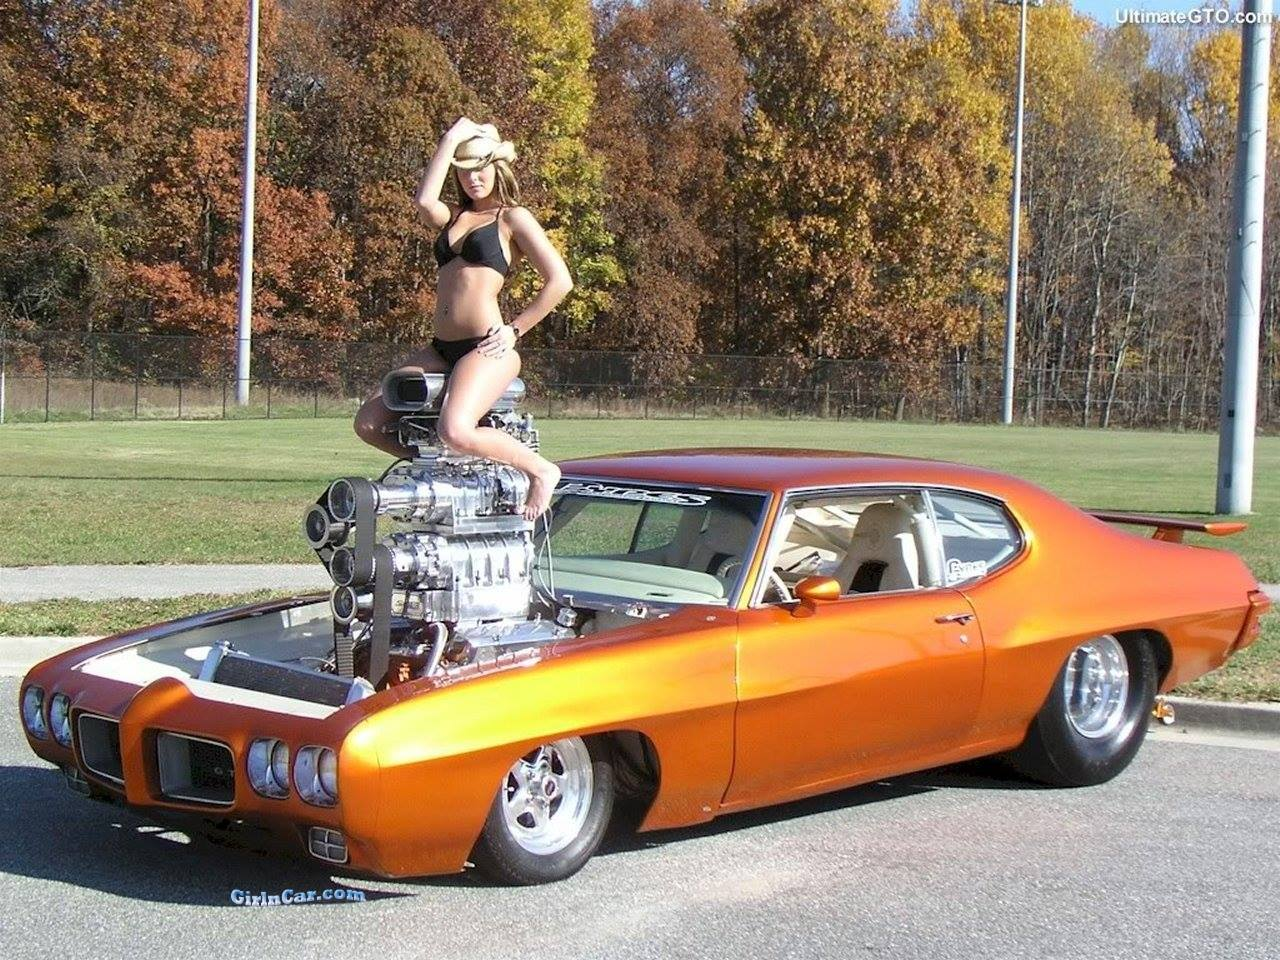

In [643]:
!pip install catboost

## Импорт библиотек и загрузка данных

In [644]:
# Импортируем библиотеки, сначала те, что используются в BaseLine
# Если будем применять другие алгоритмы МО, добавим их
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [645]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [646]:
# Пользуемся датасетом с репозитория, сейчас там данные только о машинах BMW
train = pd.read_csv('C:/Users/User/Documents/GitHub/Wrecking-Crew-RDS-5/auto_ru_2508.csv')

In [647]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5594 entries, 0 to 5593
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           5594 non-null   int64  
 1   Unnamed: 0.1         5594 non-null   int64  
 2   body_type            5594 non-null   object 
 3   body_type_add        5594 non-null   object 
 4   color_hex_add        5594 non-null   object 
 5   condition            5594 non-null   float64
 6   customs              5594 non-null   float64
 7   description          5368 non-null   object 
 8   drive                5594 non-null   object 
 9   engine_displacement  5594 non-null   float64
 10  engine_power         5594 non-null   float64
 11  fuel_type            5594 non-null   object 
 12  loc_add              5594 non-null   object 
 13  location             5594 non-null   object 
 14  mileage              5594 non-null   float64
 15  model_date           5594 non-null   f

В датасете пропущены данные в признаке description (с этим придется что-то делать), model_date_add ( это не кажется проблемой ), price ( придется удалить, так как это целевая переменная ), rating ( можно заполнить, пользуясь данными о других а/м этой же модели ).

In [648]:
train.isna().sum()

Unnamed: 0                0
Unnamed: 0.1              0
body_type                 0
body_type_add             0
color_hex_add             0
condition                 0
customs                   0
description             226
drive                     0
engine_displacement       0
engine_power              0
fuel_type                 0
loc_add                   0
location                  0
mileage                   0
model_date                0
model_date_add          431
name                      0
number_of_doors           0
owners                    2
package                   0
price                    14
production_date           0
pts                       1
rating                  198
steer                     0
transmission              0
purchase_date          3439
dtype: int64

In [649]:
# В нашем репозитории лежат скачанные с Kaggle датасет тест и образец сабмита

In [650]:
test = pd.read_csv('C:/Users/User/Documents/GitHub/Wrecking-Crew-RDS-5/test.csv')

In [651]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              3837 non-null   object 
 1   brand                 3837 non-null   object 
 2   color                 3837 non-null   object 
 3   fuelType              3837 non-null   object 
 4   modelDate             3837 non-null   float64
 5   name                  3837 non-null   object 
 6   numberOfDoors         3837 non-null   float64
 7   productionDate        3837 non-null   float64
 8   vehicleConfiguration  3837 non-null   object 
 9   vehicleTransmission   3837 non-null   object 
 10  engineDisplacement    3837 non-null   object 
 11  enginePower           3837 non-null   object 
 12  description           3837 non-null   object 
 13  mileage               3837 non-null   float64
 14  Комплектация          3837 non-null   object 
 15  Привод               

В датасете test не заполнены только поля признака "Владение", возможно, его придется исключить из модели.

In [652]:
test.isna().sum()

bodyType                   0
brand                      0
color                      0
fuelType                   0
modelDate                  0
name                       0
numberOfDoors              0
productionDate             0
vehicleConfiguration       0
vehicleTransmission        0
engineDisplacement         0
enginePower                0
description                0
mileage                    0
Комплектация               0
Привод                     0
Руль                       0
Состояние                  0
Владельцы                  0
ПТС                        0
Таможня                    0
Владение                2084
id                         0
dtype: int64

In [653]:
pd.set_option('display.max_columns', 25)
test.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,0
1,седан,BMW,белый,дизель,2018.0,318d 2.0d AT (150 л.с.),4.0,2019.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,150 N12,Автомобиль из демонстрационного парка по спец ...,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,1
2,седан,BMW,синий,бензин,2009.0,550i xDrive 4.4 AT (407 л.с.) 4WD,4.0,2012.0,SEDAN AUTOMATIC 4.4,автоматическая,4.4 LTR,407 N12,Машина собиралась под заказ! \r\n\r\n,120000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,7 лет и 2 месяца,2
3,внедорожник 5 дв.,BMW,белый,дизель,2014.0,30d 3.0d AT (249 л.с.) 4WD,5.0,2015.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,249 N12,АВТОМОБИЛЬ В БЕЗУПРЕЧНОМ ВНЕШНЕМ И ТЕХНИЧЕСКОМ...,111466.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,NaN,3
4,внедорожник 5 дв.,BMW,синий,дизель,2014.0,M50d 3.0d AT (381 л.с.) 4WD,5.0,2019.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,381 N12,Автомобиль не имеет собственников ( физ. лиц) ...,11891.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,4


In [654]:
pd.set_option('display.max_columns', 30)
train.head()

,Unnamed: 0,Unnamed: 0.1,body_type,body_type_add,color_hex_add,condition,customs,description,drive,engine_displacement,engine_power,fuel_type,loc_add,location,mileage,model_date,model_date_add,name,number_of_doors,owners,package,price,production_date,pts,rating,steer,transmission,purchase_date
0,0,0,ALLROAD_5_DOORS,Внедорожник 5 дв.,040001,1.0,1.0,"Автомобиль в идеальном состоянии,все исправно ...",ALL_WHEEL_DRIVE,2979.0,306.0,GASOLINE,Москва,Москва,137000.0,2007.0,2012.0,35i 3.0 AT (306 л.с.) 4WD,5.0,1.0,"{'front-seats-heat-vent': True, 'esp': True, '...",1250000.0,2010.0,ORIGINAL,4.6,LEFT,AUTOMATIC,NaN
1,1,1,SEDAN,Седан Long,FAFBFB,1.0,1.0,\nP337A\tСпортивный комплект стиль M\nP7GZA\tE...,ALL_WHEEL_DRIVE,2993.0,265.0,DIESEL,Москва,Москва,29000.0,2015.0,2019.0,730Ld xDrive 3.0d AT (265 л.с.) 4WD,4.0,2.0,{},3400000.0,2016.0,ORIGINAL,4.6,LEFT,AUTOMATIC,NaN
2,2,2,SEDAN,Седан,040001,1.0,1.0,"Продаётся BMW 525 d xdrive, два ключа. Я собст...",ALL_WHEEL_DRIVE,1995.0,218.0,DIESEL,Москва,Москва,119458.0,2013.0,2017.0,525d xDrive 2.0d AT (218 л.с.) 4WD,4.0,3.0,{},1295000.0,2013.0,ORIGINAL,4.8,LEFT,AUTOMATIC,NaN
3,3,3,ALLROAD_5_DOORS,Внедорожник 5 дв.,040001,1.0,1.0,«Inchcape Certified- Первый международный офи...,ALL_WHEEL_DRIVE,1995.0,150.0,DIESEL,Москва,Москва,4500.0,2015.0,2019.0,18d xDrive 2.0d AT (150 л.с.) 4WD,5.0,2.0,"{'cruise-control': True, 'esp': True, 'usb': T...",1679000.0,2017.0,ORIGINAL,4.7,LEFT,AUTOMATIC,NaN
4,4,4,SEDAN,Седан,0000CC,1.0,1.0,"Новый автомобиль! богатая комплектация, обвес ...",ALL_WHEEL_DRIVE,1998.0,249.0,GASOLINE,Москва,Москва,14000.0,2016.0,2020.0,530i xDrive 2.0 AT (249 л.с.) 4WD,4.0,1.0,"{'cruise-control': True, 'asr': True, 'esp': T...",3150000.0,2019.0,ORIGINAL,4.6,LEFT,AUTOMATIC,NaN


In [655]:
# def param_data(data): # посмотрим на данные
#     param = pd.DataFrame({
#               'dtypes': data.dtypes.values,
#               'nunique': data.nunique().values,
#               'isna': data.isna().sum().values,
#               'loc[0]': data.loc[0].values,
#               }, 
#              index = data.loc[0].index)
#     return param

## Первоначальный осмотр и попытка извлечения информации

### Определение необходимых функций

In [656]:
# Один из вариантов - разбить числовой признак на группы
def binned(row):
#     Разбивает ячейки колонки датасета на группы в зависимости от границ разбиения (список границ - lst)

    global lst
    n = len(lst)
    if pd.isna(row):
        return np.nan
    
    if row>=lst[-1]:
        return lst[-1]
    
    if row<lst[0]:
        return 0
    
    for i in range(1,n):
        if row<lst[i]:
            return lst[i-1]

In [657]:
# Функция, считающая нашу целевую метрику
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [1013]:
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape_ = mape(y_true, y_pred)
    print(
        f'RMSE = {rmse:.2f}, MAE = {mae:.2f}, R-sq = {r2:.2f}, MAPE = {mape_:.3f} ')

### Целевая переменная price

Присутствует только в трейне. Удаляем из трейна 14 записей с пропуском цены.

In [658]:
len(train)

5594

In [659]:
# Удалим 14 записей без цены
train.dropna(subset=['price'],inplace=True)

In [660]:
len(train)

5580

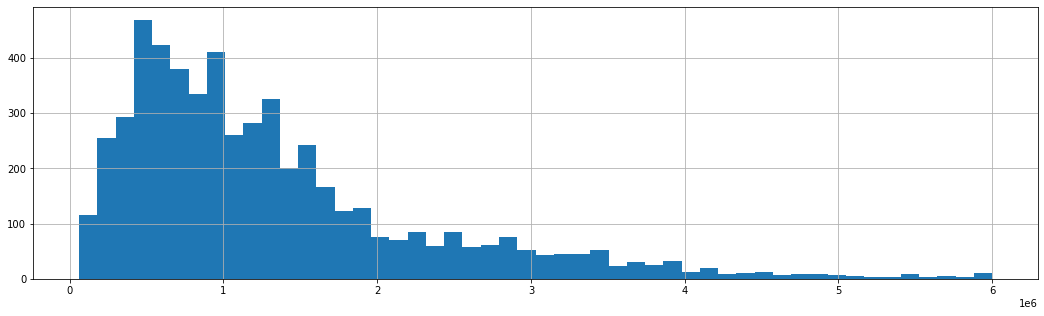

In [661]:
plt.figure(figsize=(18,5))
train[train.price<6000000].price.hist(bins=50);

Распределение признака имеет длинный правый хвост, он нуждается в логарифмировании

In [662]:
train['price_log'] = train.price.apply(lambda cell: np.log(cell + 1))

In [663]:
PRICE_LOG_MEDIAN = train.price_log.median()
train['price_log'] = train['price_log']/PRICE_LOG_MEDIAN

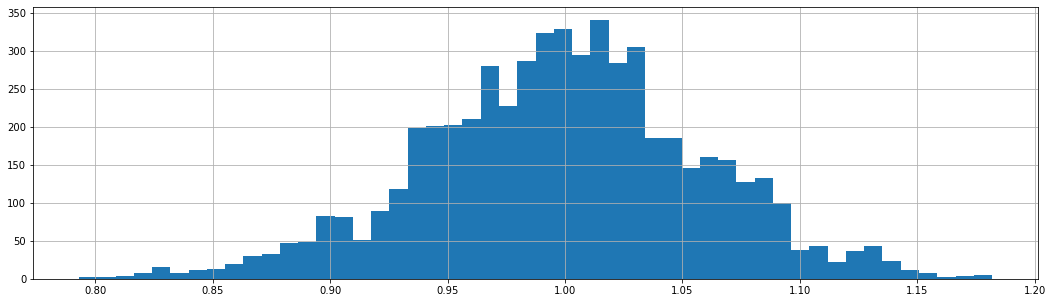

In [664]:
plt.figure(figsize=(18,5))
train.price_log.hist(bins=50);

In [665]:
# из 5580 записей в трейне 5348 округлены минимум до 1000 рублей. Возможно, сабмит придется округлять
len(train[(train.price//1000)*1000==train.price])

5348

In [666]:
len(train)

5580

In [667]:
# Рассмотрим результат применения обратной функции к логарифму цены
t = train['price_log'].apply(lambda row: (np.exp(row*PRICE_LOG_MEDIAN) - 1))

In [668]:
len(t)

5580

Сразу же сравним MAPE между исходной ценой и ценой после обратного пересчета логарифма, в случаях без округления и с округлением.

In [669]:
# Без округления
mape(train['price'], t)

6.902651403332272e-16

In [670]:
# С округлением
mape(train['price'], np.round(t/1000)*1000)

3.059797190341111e-06

__Пока кажется, что округление только повредит, но мы проверим еще раз после прогноза__

### bodyType

Возможно, этот признак дублирует информацию признаков name и description и нам не понадобится. Кроме того, надо унифицировать название признака и его значения.

In [671]:
train.body_type.value_counts(dropna=False)

SEDAN                2583
ALLROAD_5_DOORS      2122
COUPE                 287
HATCHBACK_5_DOORS     211
LIFTBACK              150
WAGON_5_DOORS          69
HATCHBACK_3_DOORS      61
CABRIO                 50
ROADSTER               28
COMPACTVAN             10
SEDAN_2_DOORS           8
COUPE_HARDTOP           1
Name: body_type, dtype: int64

In [672]:
test.bodyType.value_counts(dropna=False)

внедорожник 5 дв.    1626
седан                1594
купе                  214
хэтчбек 5 дв.         163
лифтбек               125
универсал 5 дв.        46
хэтчбек 3 дв.          36
кабриолет              19
родстер                10
компактвэн              3
седан 2 дв.             1
Name: bodyType, dtype: int64

In [673]:
test.bodyType = test.bodyType.map({'внедорожник 5 дв.':'ALLROAD_5_DOORS',
                                   'седан':'SEDAN',
                                   'купе':'COUPE',
                                   'хэтчбек 5 дв.':'HATCHBACK_5_DOORS',
                                   'лифтбек':'LIFTBACK',
                                   'универсал 5 дв.':'WAGON_5_DOORS',
                                   'хэтчбек 3 дв.':'HATCHBACK_3_DOORS',
                                   'кабриолет':'CABRIO',
                                   'родстер':'ROADSTER',
                                   'компактвэн':'COMPACTVAN',
                                   'седан 2 дв.':'SEDAN_2_DOORS',
                                  })

In [674]:
test.rename(columns={'bodyType':'body_type'},inplace=True)

In [675]:
# Проверяем - правильно
test.body_type.value_counts(dropna=False)

ALLROAD_5_DOORS      1626
SEDAN                1594
COUPE                 214
HATCHBACK_5_DOORS     163
LIFTBACK              125
WAGON_5_DOORS          46
HATCHBACK_3_DOORS      36
CABRIO                 19
ROADSTER               10
COMPACTVAN              3
SEDAN_2_DOORS           1
Name: body_type, dtype: int64

In [676]:
# В Трейне есть категория, которой нет в тесте, нам это не страшно
list(set(test.body_type.unique()) ^ set(train.body_type.unique()))

['COUPE_HARDTOP']

In [677]:
# собираем признаки, которые точно поставим в модель
cols_for_model = []
cols_for_model.append('body_type')

In [678]:
# собираем признаки, про которые подумаем
cols_optional = []

### color

Цвета в базе auto.ru заданы в шестнадцатеричном формате. Задача - из объявлений и,или https://www.colorhexa.com/ сопоставить тест и трейн. И унифицировать название колонки. Цвета разных марок машин, воспринимаемые людьми как одинаковые, на самом деле различаются. Корректно задает цвет его шестнадцатеричный код. Для BMW мы его можем привести в файле Тест точно. Если в файле Трейн будут машины других марок, возможно, придется "развернуть" словарь цветов и привести их к тем, как они воспринмаются человеком.

In [679]:
train.color_hex_add.value_counts(dropna=False)

040001    2203
FAFBFB     939
0000CC     710
97948F     676
CACECB     348
200204     204
EE1D19     171
007F00     100
22A0F8      63
C49648      63
DEA522      31
660099      27
FF8649      22
4A2197      16
FFD600       6
FFC0CB       1
Name: color_hex_add, dtype: int64

In [680]:
test.color.value_counts(dropna=False)

чёрный         1395
белый           767
синий           510
серый           453
коричневый      216
серебристый     191
красный         115
бежевый          46
голубой          35
зелёный          33
оранжевый        27
золотистый       23
пурпурный        20
фиолетовый        5
жёлтый            1
Name: color, dtype: int64

In [681]:
test.color = test.color.map({'чёрный':'040001',
                                   'белый':'FAFBFB',
                                   'синий':'0000CC',
                                   'серый':'97948F',
                                   'коричневый':'200204',
                                   'серебристый':'CACECB',
                                   'красный':'EE1D19',
                                   'бежевый':'C49648',
                                   'голубой':'22A0F8',
                                   'зелёный':'007F00',
                                   'оранжевый':'FF8649',
                                   'золотистый':'DEA522',
                                   'пурпурный':'660099',
                                   'фиолетовый':'4A2197',
                                   'жёлтый':'FFD600',
                                  })

In [682]:
test.rename(columns={'color':'color_hex_add'},inplace=True)

In [683]:
# В Трейне есть категория, которой нет в тесте, нам это не страшно
list(set(test.color_hex_add.unique()) ^ set(train.color_hex_add.unique()))

['FFC0CB']

In [684]:
cols_for_model.append('color_hex_add')

In [685]:
len(train)

5580

### fuelType

Тип топлива сопоставить легко. И унифицировать название колонки.

In [686]:
train.fuel_type.value_counts(dropna=False)

GASOLINE    3891
DIESEL      1661
HYBRID        16
ELECTRO       12
Name: fuel_type, dtype: int64

In [687]:
test.fuelType.value_counts(dropna=False)

бензин     2471
дизель     1358
гибрид        7
электро       1
Name: fuelType, dtype: int64

In [688]:
test.fuelType = test.fuelType.map({'бензин':'GASOLINE',
                                   'дизель':'DIESEL',
                                   'гибрид':'HYBRID',
                                   'электро':'ELECTRO',
                                  })

In [689]:
test.rename(columns={'fuelType':'fuel_type'},inplace=True)

In [690]:
cols_for_model.append('fuel_type')

In [691]:
len(train)

5580

### modelDate

Для CatBoost признак надо превратить в целочисленный. Для цены машины в нашем диапазоне возрастов большее значение имеет возраст модели.

In [692]:
# train.model_date.value_counts(dropna=False).sort_index()

In [693]:
# train.drop(train[train.model_date<1975.0].index,inplace=True)

In [694]:
# Мы удалили 13 записей о машинах старше 1975 модельного года
len(train)

5580

In [695]:
# test.modelDate.value_counts(dropna=False).sort_index()

In [696]:
test.rename(columns={'modelDate':'model_date'},inplace=True)

In [697]:
# В Трейне есть категории, которых нет в тесте, нам это не страшно
list(set(test.model_date.unique()) ^ set(train.model_date.unique()))

[1936.0,
 1937.0,
 1949.0,
 1966.0,
 1968.0,
 1972.0,
 1976.0,
 1988.0,
 1989.0,
 1997.0]

In [698]:
# вводим возраст
train['model_age'] = 2020 - train.model_date
test['model_age'] = 2020 - test.model_date

In [699]:
# это будет числовая колонка
train.model_age = train.model_age.astype('int32')
test.model_age = test.model_age.astype('int32')
train.model_date = train.model_date.astype('int32')
test.model_date = test.model_date.astype('int32')

In [700]:

cols_for_model.append('model_age')
cols_optional.append('model_date')

### vehicleTransmission 

Или унифицировать значения, или дропнуть, оставив сложный признак vehicleConfiguration и синтезировав его же в трейне.

In [701]:
train.transmission.value_counts(dropna=False)

AUTOMATIC     5080
MECHANICAL     424
ROBOT           76
Name: transmission, dtype: int64

In [702]:
test.vehicleTransmission.value_counts(dropna=False)

автоматическая      3677
механическая         111
роботизированная      49
Name: vehicleTransmission, dtype: int64

In [703]:
test.vehicleTransmission = test.vehicleTransmission.map({'автоматическая':'AUTOMATIC',
                                              'механическая':'MECHANICAL',
                                              'роботизированная':'ROBOT',
                                               })

In [704]:
test.rename(columns={'vehicleTransmission':'transmission'},inplace=True)

In [705]:
cols_for_model.append('transmission')

In [706]:
len(train)

5580

### name

Признак содержит все сведения об основном оборудовании автомобиля.Вероятно, надо проверить совпадение написания значений признака. Может, его придется разбить на составные части ( возможно, что разные значения этого признака представляют собой близко родственные модификации, то есть их цены должны быть близкими(?). 

In [707]:
# pd.set_option('display.max_rows', 500)
train.name.value_counts(dropna=False).sample(10)

735i 3.4 MT (192 л.с.)                 1
218d 2.0d AT (150 л.с.)                2
318d 2.0d AT (150 л.с.)                1
1.9 AT (140 л.с.)                      1
318d 2.0d AT (143 л.с.)                2
630i 3.0 AT (272 л.с.)                 9
4.0 AMT (420 л.с.)                    16
530xd 3.0d AT (235 л.с.) 4WD           3
645i 4.4 MT (333 л.с.)                 2
420d xDrive 2.0d AT (190 л.с.) 4WD    11
Name: name, dtype: int64

In [708]:
# Очевидно, простой сплит не работает
s = train.name.apply(lambda x: x.split(' '))

In [709]:
s.head(10)

0               [35i, 3.0, AT, (306, л.с.), 4WD]
1    [730Ld, xDrive, 3.0d, AT, (265, л.с.), 4WD]
2     [525d, xDrive, 2.0d, AT, (218, л.с.), 4WD]
3      [18d, xDrive, 2.0d, AT, (150, л.с.), 4WD]
4      [530i, xDrive, 2.0, AT, (249, л.с.), 4WD]
5               [20i, 2.0, AT, (184, л.с.), 4WD]
6                        [4.4, AMT, (560, л.с.)]
7              [30d, 3.0d, AT, (249, л.с.), 4WD]
8                        [4.4, AMT, (560, л.с.)]
9                        [4.4, AMT, (560, л.с.)]
Name: name, dtype: object

In [710]:
# Напишем функцию для извлечения нескольких признаков из признака name. Возможно, эти признаки нам пригодятся.
def name_to_features(row_glob):
    row = row_glob
    try:
        l1 = re.search(r'(\d{2,} л.с.)',row)
    #    print(l1[0])
        row = row.replace(l1[0],'')
        power = int(l1[0].split(' ')[0])    
    except TypeError:
        power = 0
    row = row.replace('()','')
    #   print(power,row)
    try:
        l1 = re.search(r'\w+T',row)
    #    print(l1[0])
        row = row.replace(l1[0],'')
        transmission = l1[0]   
    except TypeError:
        transmission = 'N'
    try:
        l1 = re.search(r'\dWD',row)
    #    print(l1[0])
        row = row.replace(l1[0],'')
        wheels = l1[0]   
    except TypeError:
        wheels = 'N'
    try:
        l1 = re.search(r'\d[.]\d\w*',row)
    #    print(l1[0])
        row = row.replace(l1[0],'')
        engine = l1[0]   
    except TypeError:
        engine = 'N' 
    try:
        l1 = re.search(r'\wDrive',row)
    #    print(l1[0])
        row = row.replace(l1[0],'')
        drive = l1[0]   
    except TypeError:
        drive = 'N'
    try:
        mark = row.replace(' ','')
    #    print(mark)   
    except TypeError:
        mark = 'N'
    return mark, drive, engine, wheels, transmission, power

In [711]:
# Извлекаем из трейн
train['mark_'] = 'N'
train['drive_'] = 'N'
train['engine_'] = 'N'
train['wheels_'] = 'N'
train['transmission_'] = 'N'
train['power_'] = 'N'
train['mark_'],train['drive_'],train['engine_'],train['wheels_'],train['transmission_'],train['power_'] = \
zip(*train.name.map(name_to_features))

In [712]:
# Извлекаем из test
test['mark_'] = 'N'
test['drive_'] = 'N'
test['engine_'] = 'N'
test['wheels_'] = 'N'
test['transmission_'] = 'N'
test['power_'] = 'N'
test['mark_'],test['drive_'],test['engine_'],test['wheels_'],test['transmission_'],test['power_'] = \
zip(*test.name.map(name_to_features))

In [713]:
# 'drive_', engine_, wheels_, transmission_, power_  - нам уже знакомы, мы уже имеем похожие.

In [714]:
# Это единственный признак, который нам не знаком. Проверим, совпадают ли категории признака в трейн и тест
tst_mk_lst = test['mark_'].unique().tolist()
trn_mk_lst = train['mark_'].unique().tolist()

In [715]:
trn_mk_lst = train['mark_'].unique().tolist()

In [716]:
# trn_mk_lst - одно из значений - пробел. Не знаю, проблема ли это.

In [717]:
# Выясняем, в чем разница
diff = [name for name in tst_mk_lst if name not in trn_mk_lst]

In [718]:
# Это спортвная машина высокого класса, дорогая. Возможно, мы будем ошибаться в ее цене.
diff

['CS']

In [719]:
cols_for_model.append('mark_')

In [720]:
cols_for_model.append('engine_')

In [721]:
cols_optional.append('power_')

In [722]:
cols_optional = []
cols_optional.append('drive_')

In [723]:
cols_optional.append('wheels_')

In [724]:
cols_for_model

['body_type',
 'color_hex_add',
 'fuel_type',
 'model_age',
 'transmission',
 'mark_',
 'engine_']

### Рыночная доля марки

Под рыночной долей данной марки автомобиля мы будем подразумевать величину, пропорциональную проценту автомобилей данной марки в трейне, учитывая ( дальше будет видно как ) год начала выпуска данной марки.

In [725]:
df_mark = train.groupby(by='mark_').agg({'price':'count'}).rename({'price':'count_'},axis='columns')

In [726]:
# df_mark

In [727]:
train = train.join(df_mark, on='mark_')

In [728]:
pd.set_option('display.max_columns',65)
train[['mark_','count_']] .head()

,mark_,count_
0,35i,279
1,730Ld,49
2,525d,51
3,18d,22
4,530i,94


In [729]:
test = test.join(df_mark, on='mark_')

In [730]:
test[['mark_','count_']] .head()

,mark_,count_
0,520d,214.0
1,318d,9.0
2,550i,17.0
3,30d,315.0
4,M50d,57.0


Сгруппируем count автомобилей каждой марки по величине

In [731]:
lst = [2**i for i in range(10)]
lst

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

In [732]:
# test.count_.value_counts(dropna=False).sort_index()
# Мы помним, что одна машина из теста не вошла в категории марок
test['count_'].fillna(1,inplace=True)

In [733]:
train['count_binned'] = train['count_'].apply(binned).astype('int32')
test['count_binned'] = test['count_'].apply(binned).astype('int32')

In [734]:
train['count_binned'].value_counts(dropna=False).sort_index()

1        32
2        58
4       109
8       210
16      351
32      758
64     1023
128    1509
256    1530
Name: count_binned, dtype: int64

In [735]:
test['count_binned'].value_counts(dropna=False).sort_index()

1        26
2        31
4        59
8       118
16      242
32      478
64      795
128    1047
256    1041
Name: count_binned, dtype: int64

In [736]:
cols_for_model.append('count_binned')

### numberOfDoors 

Все хорошо совпадает, кроме названия признака. Сделаем значения признака целыми

In [737]:
train.number_of_doors.value_counts(dropna=False)

4.0    2583
5.0    2562
2.0     374
3.0      61
Name: number_of_doors, dtype: int64

In [738]:
test.numberOfDoors.value_counts(dropna=False)

5.0    1963
4.0    1594
2.0     244
3.0      36
Name: numberOfDoors, dtype: int64

In [739]:
test.rename(columns={'numberOfDoors':'number_of_doors'},inplace=True)

In [740]:
train.number_of_doors = train.number_of_doors.astype('str')
test.number_of_doors = test.number_of_doors.astype('str')

In [741]:
cols_for_model.append('number_of_doors')

### productionDate 

Нам интересен возраст автомобиля ( "18-летняя девушка" звучит более привлекательно, чем " 18-летняя машина" ). И интересна величина, обратная возрасту ( так как цена падает с возрастом при прочих равных ). Если мы удалим авто раньше 1975 модельного года, этот признак будет в порядке. Сделаем значения возраста целочисленными. Вопрос для обсуждения: стоит ли их разбить на группы по возрастам?

In [742]:
# train.production_date.value_counts(dropna=False).sort_index()

In [743]:
# test.productionDate.value_counts(dropna=False).sort_index()

In [744]:
# Судя по датам в описании машин, база тест собиралась в конце 2019 или в самом начале 2020 года
train['age'] = 2020 - train.production_date
test['age'] = 2019 - test.productionDate

In [745]:
#  test.age.value_counts(dropna=False).sort_index()

In [746]:
# Один из вариантов - разбить числовой признак на группы
# создадим вменяемый ряд возрастов в виде геометрической прогрессии
lst = [3**i for i in range(3)]
lst

[1, 3, 9]

In [747]:
train['age_binned'] = train.age.apply(binned)

In [748]:
test['age_binned'] = test.age.apply(binned)

In [749]:
test['age_binned'].value_counts()

3    1958
9    1154
1     463
0     262
Name: age_binned, dtype: int64

In [750]:
#  сделаем признак, обратный возрасту, добавив единицу, чтобы избежать деления на ноль
train['age_reciprocal'] = (100/(1 + train.age_binned)).astype('int32')
test['age_reciprocal'] = (100/(1 + test.age_binned)).astype('int32')

In [751]:
train.age_reciprocal.value_counts()

10     3001
25     1976
50      530
100      73
Name: age_reciprocal, dtype: int64

In [752]:
test.age_reciprocal.value_counts()

25     1958
10     1154
50      463
100     262
Name: age_reciprocal, dtype: int64

In [753]:
# признак возраста сделаем целочисленным
train.age = train.age.astype('int32')
test.age = test.age.astype('int32')

In [754]:
cols_for_model.append('age')
cols_for_model.append('age_reciprocal')
cols_optional.append('age_binned')

### vehicleConfiguration

Этого признака нет в результате парсинга, но он, похоже, объединяет в себе тип кузова, количество дверей, тип трансмиссии и примерный объем двигателя в литрах. Выходы: удалить признак из теста или сделать аналогичный в трейне (возможно, второй выход лучше, он похож на кластеризацию). В результате исследования оказалось, что группировать категориальные признаки - тупиковая(?) идея.

In [755]:
# train.vehicleConfiguration.value_counts(dropna=False)

In [756]:
# Соберем все конфигурации в список:
vconfig_lst = test.vehicleConfiguration.unique().tolist()

In [757]:
# vconfig_lst

In [758]:
# В списке есть конфигурации без указания объема двигателя
special_v = [x for x in vconfig_lst if len(x.split(' '))<3]

In [759]:
special_v

['HATCHBACK_5_DOORS AUTOMATIC']

In [760]:
# При этом типы кузова почти такие же, как в train.body_type, там есть только одна машина COUPE_HARDTOP
v1 = set([x.split(' ')[0] for x in vconfig_lst])

In [761]:
v1

{'ALLROAD_5_DOORS',
 'CABRIO',
 'COMPACTVAN',
 'COUPE',
 'HATCHBACK_3_DOORS',
 'HATCHBACK_5_DOORS',
 'LIFTBACK',
 'ROADSTER',
 'SEDAN',
 'SEDAN_2_DOORS',
 'WAGON_5_DOORS'}

In [762]:
train.body_type.value_counts()

SEDAN                2583
ALLROAD_5_DOORS      2122
COUPE                 287
HATCHBACK_5_DOORS     211
LIFTBACK              150
WAGON_5_DOORS          69
HATCHBACK_3_DOORS      61
CABRIO                 50
ROADSTER               28
COMPACTVAN             10
SEDAN_2_DOORS           8
COUPE_HARDTOP           1
Name: body_type, dtype: int64

In [763]:
# В типах трансмиссии все совпадает
v2 = set([x.split(' ')[1] for x in vconfig_lst])

In [764]:
v2

{'AUTOMATIC', 'MECHANICAL', 'ROBOT'}

In [765]:
train.transmission.value_counts()

AUTOMATIC     5080
MECHANICAL     424
ROBOT           76
Name: transmission, dtype: int64

In [766]:
train.transmission_.value_counts()

AT     5080
MT      424
AMT      76
Name: transmission_, dtype: int64

In [767]:
# Список всех значений объема двигателя в трейне ( помним, что N - означает электрический привод)
v_train = list(set([vol[:3] for vol in train.engine_.tolist()]))

In [768]:
v3 = list(set([x.split(' ')[-1] for x in vconfig_lst]))

In [769]:
# Мы помним, что 'AUTOMATIC' оказалось в списке объемов ошибочно
v3.remove('AUTOMATIC')
# v3

In [770]:
# test.engine_.value_counts()

In [771]:
# Мы помним, что электрические машины не имеют объема двигателя
test[test.engine_.str.contains('N')]

,body_type,brand,color_hex_add,fuel_type,model_date,name,number_of_doors,productionDate,vehicleConfiguration,transmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id,model_age,mark_,drive_,engine_,wheels_,transmission_,power_,count_,count_binned,age,age_binned,age_reciprocal
823,HATCHBACK_5_DOORS,BMW,FAFBFB,ELECTRO,2013,Electro AT (126 кВт),5.0,2016.0,HATCHBACK_5_DOORS AUTOMATIC,AUTOMATIC,undefined LTR,170 N12,Комплектация с Rex(бензиновый генератор которы...,52900.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,823,7,Electro(126кВт),N,N,N,AT,0,7.0,4,3,3,25


In [772]:
# Мы также в состоянии сделать признак конфигурации автомобиля единообразно в трейне и тесте
test['vehicle_configuration'] = test.body_type + ' ' + test.transmission + ' ' + test.engine_


In [773]:
tst_vconf_lst = test.vehicle_configuration.unique().tolist()

In [774]:
train['vehicle_configuration'] = train.body_type + ' ' + train.transmission + ' ' + train.engine_


In [775]:
trn_vconf_lst = train.vehicle_configuration.unique().tolist()

In [776]:
diff_conf = [x for x in tst_vconf_lst if x not in trn_vconf_lst]

In [777]:
# Это то, почему не проходит группировка категориальных признаков: в тесте появляются категории, котоорых нет
# в трейне, соответственно, модель даже минимально ничему не научится для этих категорий.
diff_conf

['ROADSTER AUTOMATIC 2.2',
 'WAGON_5_DOORS MECHANICAL 2.8',
 'CABRIO MECHANICAL 2.5',
 'WAGON_5_DOORS MECHANICAL 1.6',
 'SEDAN MECHANICAL 4.4',
 'HATCHBACK_5_DOORS MECHANICAL 3.0',
 'ALLROAD_5_DOORS AUTOMATIC 1.5',
 'HATCHBACK_3_DOORS AUTOMATIC 2.5',
 'WAGON_5_DOORS MECHANICAL 2.2',
 'ROADSTER AUTOMATIC 1.5hyb']

In [778]:
# отнесем конфигурацию в список опциональных признаков
cols_optional.append('vehicle_configuration')

### engineDisplacement

Варианты - дропнуть, так как признак есть в name и vehicle_configuration, или оставить, приведя к единому ряду значений и наименованию самого признака.
В трейне - это точный объем двигателя в кубических сантиметрах, в тесте - приблизительный в литрах. Решение - привести объем к кубическим сантиметрам, а электрическим машинам присвоить значение 0.

In [779]:
print(train.engine_displacement.dtype)
# train.engine_displacement.value_counts(dropna=False).sort_index()

float64


In [780]:
# Перспективнее извлечь объем двигателя в литрах из признака engine_, видоизменив его.
train['engine_vol'] = train.engine_.apply(lambda x: x[:3])

In [781]:
train['engine_vol'].value_counts(dropna=False).sort_index()

0.7       9
1.5      72
1.6     211
1.7       1
1.8      49
1.9      25
2.0    1936
2.2      59
2.4       3
2.5     504
2.8      52
2.9       6
3.0    1957
3.2       2
3.4       9
3.5      16
3.6       8
3.8       1
4.0      32
4.4     456
4.6       7
4.8     120
4.9       1
5.0      13
5.4       2
6.0      12
6.6       5
N        12
Name: engine_vol, dtype: int64

In [782]:
# У электрических машин заменим объем двигателя на 0
train.loc[train.engine_vol=='N','engine_vol'] = '0'

In [783]:
print(test.engineDisplacement.dtype)
test.engineDisplacement.value_counts(dropna=False).sort_index()

object


1.5 LTR            66
1.6 LTR           173
1.8 LTR            10
1.9 LTR             7
2.0 LTR          1538
2.2 LTR            20
2.5 LTR           239
2.8 LTR            14
2.9 LTR             4
3.0 LTR          1353
3.4 LTR             1
3.5 LTR             4
3.6 LTR             3
4.0 LTR            13
4.4 LTR           305
4.6 LTR             4
4.8 LTR            64
5.0 LTR             3
5.4 LTR             6
6.0 LTR             5
6.6 LTR             4
undefined LTR       1
Name: engineDisplacement, dtype: int64

In [784]:
# test - поступаем аналогично.
test['engine_vol'] = test.engine_.apply(lambda x: x[:3])
test.loc[test.engine_vol=='N','engine_vol'] = '0'

In [785]:
test['engine_vol'].value_counts(dropna=False).sort_index()

0         1
1.5      66
1.6     173
1.8      10
1.9       7
2.0    1538
2.2      20
2.5     239
2.8      14
2.9       3
3.0    1354
3.4       1
3.5       4
3.6       3
4.0      13
4.4     305
4.6       4
4.8      64
5.0       3
5.4       6
6.0       5
6.6       4
Name: engine_vol, dtype: int64

In [786]:
# Переведем объем в кубические сантиметры
train['engine_vol'] = (np.float32(train['engine_vol'])*1000).astype('int32')
test['engine_vol'] = (np.float32(test['engine_vol'])*1000).astype('int32')

In [787]:
# Проверим, все ли категории объема двигатела из test присутствуют в train. Ура, все категории есть.
trn_vol_lst = train['engine_vol'].unique().tolist()
tst_vol_lst = test['engine_vol'].unique().tolist()
diff_vol = [i for i in tst_vol_lst if i not in trn_vol_lst]
diff_vol

[]

In [788]:
cols_for_model.append('engine_vol')

In [789]:
# train.engine_.value_counts()

In [790]:
train.engine_vol.value_counts(dropna=False).sort_index()

0         12
700        9
1500      72
1600     211
1700       1
1800      49
1900      25
2000    1936
2200      59
2400       3
2500     504
2800      52
2900       6
3000    1957
3200       2
3400       9
3500      16
3600       8
3800       1
4000      32
4400     456
4600       7
4800     120
4900       1
5000      13
5400       2
6000      12
6600       5
Name: engine_vol, dtype: int64

__Второй вариант - оставить в категориях буквы__. Надо проверить, с каким из них модель сработает лучше.

In [791]:
tst_eng_lst = test.engine_.unique().tolist()

In [792]:
trn_eng_lst = train.engine_.unique().tolist()

In [793]:
diff_eng = [x for x in tst_eng_lst if x not in trn_eng_lst]

In [794]:
# Ура! Трейн покрывает все категории теста. В качестве признака можно использовать engine_ - мы это уже сделали
diff_eng

[]

In [795]:
cols_for_model

['body_type',
 'color_hex_add',
 'fuel_type',
 'model_age',
 'transmission',
 'mark_',
 'engine_',
 'count_binned',
 'number_of_doors',
 'age',
 'age_reciprocal',
 'engine_vol']

In [796]:
len(train)

5580

### enginePower

Варианты - дропнуть, так как признак есть в name и vehicle_configuration, или оставить, приведя к единому ряду значений и наименованию самого признака. Созраняя признак. надо проверить, с каким его видом модель сработает лучше - с строкой или числом.

In [797]:
print(train.engine_power.dtype)
pd.set_option('display.max_rows', 85)
# train.engine_power.value_counts(dropna=False).sort_index()

float64


In [798]:
train.engine_power = train.engine_power.apply(lambda row: int(row))

In [799]:
test.enginePower = test.enginePower.apply(lambda row: row.split(' ')[0]).apply(int)

In [800]:
print(test.enginePower.dtype)
pd.set_option('display.max_rows', 75)
# test.enginePower.value_counts(dropna=False).sort_index()

int64


In [801]:
trn_pow_lst = train.engine_power.unique().tolist()

In [802]:
tst_pow_lst = test.enginePower.unique().tolist()

In [803]:
diff_pow = [x for x in tst_pow_lst if x not in trn_pow_lst]

In [804]:
# Единого ряда так и не получилось. Разбивать признак на группы ( корзины ) нецелесообразно,
# так как он распределен неравномерно.
diff_pow

[460, 374, 252, 410, 449, 243, 230]

In [805]:
test.rename(columns={'enginePower':'engine_power'},inplace=True)

In [806]:
# Будем применять его как целочисленный, чтобы избежать лишних категорий в тесте
train['engine_power'] = train['engine_power'].astype('int32')
test['engine_power'] = test['engine_power'].astype('int32')

In [807]:
train['engine_power'].value_counts(dropna=False).sort_index()

46      5
51      5
75      1
90      6
98      1
       ..
575    44
600     5
609     2
610     3
625    12
Name: engine_power, Length: 82, dtype: int64

In [808]:
# сделаем признак, сгруппировав авто по мощности
lst = [20*(i + 5) for i in range(25)]
lst

[100,
 120,
 140,
 160,
 180,
 200,
 220,
 240,
 260,
 280,
 300,
 320,
 340,
 360,
 380,
 400,
 420,
 440,
 460,
 480,
 500,
 520,
 540,
 560,
 580]

In [809]:
train['power_binned'] = train.engine_power.apply(binned)
test['power_binned'] = test.engine_power.apply(binned)

In [810]:
cols_for_model.append('engine_power')

In [811]:
cols_optional.append('power_binned')

### mileage

У распределения длинный правый хвост, кроме того, использовать километраж напрямую в КатБуст не получится - значения признака не будут совпадать у трейна и теста. Предложение - использовать pd.cut() или pd.qcut(), надо обсудить, что лучше. __Я решил начать пробовать с pd.cut() - так как пользуясь разбиением на квантили, мы невольно допускаем утечку данных.__ В итоге я сочинил свою функцию разбиения. Все, что нужно знать о гарантийном пробеге и сроке БМВ в России, здесь: https://www.bmw.ru/ru/topics/offers-and-services/personal-services/warranties.html

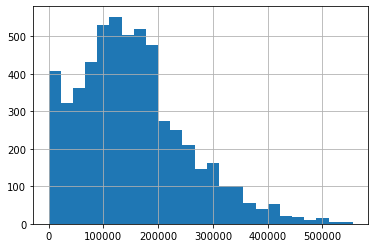

In [812]:
train[train.mileage<600000].mileage.hist(bins=25);

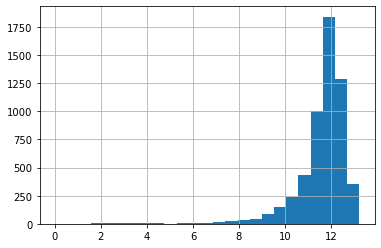

In [813]:
# Прямое логарифмирование - нас тоже не устраивает,  распределение осталось несимметричным !
np.log(train[train.mileage<600000].mileage).hist(bins=25);

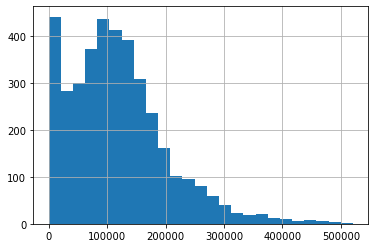

In [814]:
test[test.mileage<600000].mileage.hist(bins=25);

In [815]:
# В трейне девять машин с пробегом больше 600000 км, и они не антикварные
len(train[train.mileage>600000])

9

In [816]:
# В тесте ровно одна машина с пробегом больше 600000 км
test[test.mileage>600000]

,body_type,brand,color_hex_add,fuel_type,model_date,name,number_of_doors,productionDate,vehicleConfiguration,transmission,engineDisplacement,engine_power,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id,model_age,mark_,drive_,engine_,wheels_,transmission_,power_,count_,count_binned,age,age_binned,age_reciprocal,vehicle_configuration,engine_vol,power_binned
1228,SEDAN,BMW,040001,GASOLINE,1986,730i 3.0 MT (188 л.с.),4.0,1989.0,SEDAN MECHANICAL 3.0,MECHANICAL,3.0 LTR,188,Внимание цена снижена не на долго срочно нужна...,1000000.0,"['[{""name"":""Салон"",""values"":[""Солнцезащитная ш...",задний,Левый,Не требует ремонта,1 владелец,Дубликат,Растаможен,NaN,1228,34,730i,N,3.0,N,MT,188,30.0,16,30,9,10,SEDAN MECHANICAL 3.0,3000,180


In [817]:
# Сгруппируем машины по пробегу:
lst = [(i + 1)*25000 for i in range(20)]
lst

[25000,
 50000,
 75000,
 100000,
 125000,
 150000,
 175000,
 200000,
 225000,
 250000,
 275000,
 300000,
 325000,
 350000,
 375000,
 400000,
 425000,
 450000,
 475000,
 500000]

In [818]:
train['mileage_binned'] = train.mileage.apply(binned)

In [819]:
# train.mileage_binned.value_counts(dropna=False).sort_index()

In [820]:
test['mileage_binned'] = test.mileage.apply(binned)

In [821]:
# test.mileage_binned.value_counts(dropna=False).sort_index()

In [822]:
# Внимание! В базе тест 62 новых машины с пробегом меньше 100 км.
len(test[test.mileage<=100])

62

In [823]:
# Внимание! В базе трейн 42 новых машины с пробегом меньше 100 км.
len(train[train.mileage<=100])

43

In [824]:
train['mileage'] = train['mileage'].astype('int32')
test['mileage'] = test['mileage'].astype('int32')

In [825]:
train['mileage_binned'] = train['mileage_binned'].astype('int32')
test['mileage_binned'] = test['mileage_binned'].astype('int32')

In [826]:
# Сделаем признак интенсивности эксплуатации автомобиля - пробег в год, избегая деления на 0
train['mileage_peryear'] = ((train.mileage)/(train.age + 0.5)).astype('int32')
test['mileage_peryear'] = ((test.mileage)/(test.age + 0.5)).astype('int32')

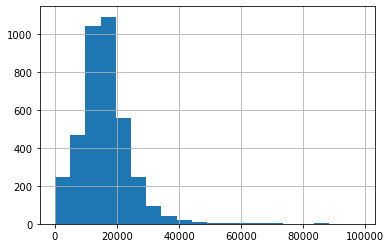

In [827]:
# Имеет смысл сделать эти признаки категориальными, разбив на группы
test['mileage_peryear'].hist(bins=20)

In [828]:
# Для интервалов годового пробега возьмем 5000 км
lst = [5000*(i + 1) for i in range(8)]
lst

[5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]

In [829]:
train.mileage_peryear = train.mileage_peryear.apply(binned).astype('int32')
test.mileage_peryear = test.mileage_peryear.apply(binned).astype('int32')

In [830]:
test.mileage_peryear.value_counts().sort_index()

0         250
5000      493
10000    1096
15000    1054
20000     547
25000     225
30000      87
35000      39
40000      46
Name: mileage_peryear, dtype: int64

In [831]:
cols_for_model.append('mileage_binned')
cols_for_model.append('mileage_peryear')

In [832]:
cols_optional.append('mileage')

In [833]:
cols_for_model

['body_type',
 'color_hex_add',
 'fuel_type',
 'model_age',
 'transmission',
 'mark_',
 'engine_',
 'count_binned',
 'number_of_doors',
 'age',
 'age_reciprocal',
 'engine_vol',
 'engine_power',
 'mileage_binned',
 'mileage_peryear']

In [834]:
cols_optional

['drive_',
 'wheels_',
 'age_binned',
 'vehicle_configuration',
 'power_binned',
 'mileage']

### Привод

Унифицируем наименование и значения. Делаем вывод, что в модель полезнее включить drive, а не wheels_.

In [835]:
train.drive.value_counts(dropna=False)

ALL_WHEEL_DRIVE    3077
REAR_DRIVE         2485
FORWARD_CONTROL      18
Name: drive, dtype: int64

In [836]:
train.wheels_.value_counts(dropna=False)

4WD    3077
N      2503
Name: wheels_, dtype: int64

In [837]:
test['Привод'].value_counts(dropna=False)

полный      2444
задний      1378
передний      15
Name: Привод, dtype: int64

In [838]:
test.rename(columns={'Привод':'drive'},inplace=True)

In [839]:
test.drive = test.drive.map({'полный':'ALL_WHEEL_DRIVE',
                                   'задний':'REAR_DRIVE',
                                   'передний':'FORWARD_CONTROL'
                                  })

In [840]:
test.drive.value_counts(dropna=False)

ALL_WHEEL_DRIVE    2444
REAR_DRIVE         1378
FORWARD_CONTROL      15
Name: drive, dtype: int64

In [841]:
cols_for_model.append('drive')

### Руль

Поскольку в тесте все машины праворульные, предлагаю дропнуть из трейна единственную леворульную. Утечка данных, но небольшая. Леков в BaseLine не дропнул этот признак. Может быть, у него в трейне были не только машины БМВ, но и Тойота, например? Возможно, категории машин других марок не научат модель чему-то хорошему, поэтому предлагаю дропнуть ( хотя бы для начала ). Хотя это указывает на знание нами тестовой выборки, а значит, утечка данных.

In [842]:
train.steer.value_counts(dropna=False)

LEFT     5579
RIGHT       1
Name: steer, dtype: int64

In [843]:
# И удалить эту машину из трейна.
train[train.steer=='RIGHT']

,Unnamed: 0,Unnamed: 0.1,body_type,body_type_add,color_hex_add,condition,customs,description,drive,engine_displacement,engine_power,fuel_type,loc_add,location,mileage,model_date,model_date_add,name,number_of_doors,owners,package,price,production_date,pts,rating,steer,transmission,purchase_date,price_log,model_age,mark_,drive_,engine_,wheels_,transmission_,power_,count_,count_binned,age,age_binned,age_reciprocal,vehicle_configuration,engine_vol,power_binned,mileage_binned,mileage_peryear
734,734,734,COMPACTVAN,Компактвэн Gran Tourer,0000CC,1.0,1.0,"Продам автомобиль, сборка Мюнхен, Бавария, экс...",FORWARD_CONTROL,1995.0,150,DIESEL,Москва,Москва,43000,2015,2018.0,218d 2.0d AT (150 л.с.),5.0,1.0,"{'asr': True, 'tinted-glass': True, 'usb': Tru...",1500000.0,2016.0,ORIGINAL,NaN,RIGHT,AUTOMATIC,"{'year': 2019, 'month': 5}",1.025025,5,218d,N,2.0d,N,AT,150,3,2,4,3,25,COMPACTVAN AUTOMATIC 2.0d,2000,140,25000,5000


In [844]:
test['Руль'].value_counts(dropna=False)

Левый    3837
Name: Руль, dtype: int64

In [845]:
test.rename(columns={'Руль':'steer'},inplace=True)

In [846]:
test.steer = test.steer.map({'Левый':'LEFT'})

In [847]:
# cols_optional.append('steer')

### Состояние

Этот признак просто не используется. В комментариях владельцы пишут "дымит", а на состоянии это не отражается. Леков дропнул состояние. Предлагаю и нам это сделать, а дефекты, ЕСЛИ удастся, извлечь из комментариев.

In [848]:
train.condition.value_counts(dropna=False)

1.0    5580
Name: condition, dtype: int64

In [849]:
test['Состояние'].value_counts(dropna=False)

Не требует ремонта    3837
Name: Состояние, dtype: int64

### Владельцы

Оставим его категориальным. Возможно, будет полезен признак, равный километражу на 1 владельца.

In [850]:
train.owners.value_counts(dropna=False)

3.0    2827
2.0    1422
1.0    1329
NaN       2
Name: owners, dtype: int64

In [851]:
train.owners.dtype

dtype('float64')

In [852]:
# Машины с неизвестным числом владельцев - весьма старые автомобили массовых моделей. 
# Поэтому заполняем пропуск модой.
train[train.owners.isna()][['name','production_date']]

,name,production_date
4132,3.0i 3.0 AT (231 л.с.) 4WD,2003.0
5540,523i 2.5 AT (177 л.с.),2005.0


In [853]:
train.owners.fillna(3.0,inplace=True)

In [854]:
train.owners = (train.owners.astype('str').apply(lambda row: row[0]))

In [855]:
train.owners.dtype

dtype('O')

In [856]:
test['Владельцы'].value_counts(dropna=False)

3 или более    1516
1 владелец     1309
2 владельца    1012
Name: Владельцы, dtype: int64

In [857]:
# Приводим в порядок наименование е значения признака
test.rename(columns={'Владельцы':'owners'},inplace=True)

In [858]:
test.owners = test.owners.apply(lambda x: x[0]).astype('str')

In [859]:
test.owners.dtype

dtype('O')

In [860]:
# Порядок!
test.owners.value_counts(dropna=False)

3    1516
1    1309
2    1012
Name: owners, dtype: int64

In [861]:
cols_for_model.append('owners')

### ПТС

In [862]:
train.pts.value_counts(dropna=False)

ORIGINAL     4715
DUPLICATE     864
NaN             1
Name: pts, dtype: int64

In [863]:
# Машина массовой серии, поэтому заполняем пропуск модой
train[train.pts.isna()][['name','production_date']]

,name,production_date
4304,323i 2.5 AT (170 л.с.),1999.0


In [864]:
train.pts.fillna('ORIGINAL',inplace=True)

In [865]:
# Необходимо унифицировать наименование и значения признака
test['ПТС'].value_counts(dropna=False)

Оригинал    3463
Дубликат     374
Name: ПТС, dtype: int64

In [866]:
test.rename(columns={'ПТС':'pts'},inplace=True)
test.pts = test.pts.map({'Оригинал':'ORIGINAL','Дубликат':'DUPLICATE'})

In [867]:
# Порядок!
test.pts.value_counts(dropna=False)

ORIGINAL     3463
DUPLICATE     374
Name: pts, dtype: int64

In [868]:
cols_for_model.append('pts')

In [869]:
cols_for_model

['body_type',
 'color_hex_add',
 'fuel_type',
 'model_age',
 'transmission',
 'mark_',
 'engine_',
 'count_binned',
 'number_of_doors',
 'age',
 'age_reciprocal',
 'engine_vol',
 'engine_power',
 'mileage_binned',
 'mileage_peryear',
 'drive',
 'owners',
 'pts']

### Таможня. 

Вероятнее всего, признак можно не использовать в модели.

In [870]:
# Вероятно, единица означает, что автомобиль растаможен.
train.customs.value_counts(dropna=False)

1.0    5580
Name: customs, dtype: int64

In [871]:
test['Таможня'].value_counts(dropna=False)

Растаможен    3837
Name: Таможня, dtype: int64

### Владение 

Сконвертируем признак в число месяцев владения. Скорее всего, категорий будет слишком много. Поэтосу мы сгруппируем их в корзины: менее 3 месяцев, 6, 9, 12, 24, 36, 48, 60, и более 60 мес.

In [872]:
train[~train.purchase_date.isna()].purchase_date.head(10)

15     {'year': 2014, 'month': 2}
26    {'year': 2018, 'month': 12}
34     {'year': 2015, 'month': 7}
37    {'year': 2013, 'month': 11}
45    {'year': 2019, 'month': 11}
46     {'year': 2012, 'month': 8}
48     {'year': 2010, 'month': 3}
55     {'year': 2018, 'month': 2}
58     {'year': 2018, 'month': 9}
62     {'year': 2019, 'month': 3}
Name: purchase_date, dtype: object

In [873]:
# Сделаем функцию перевода строки о дате приобретения в числовое значение месяцев владения
def to_months(row):
    if pd.isna(row):
        return np.nan
    else:
        newrow = ''.join((ch if ch in '0123456789' else ' ') for ch in row)
        # print(newrow)
        nums = [int(i) for i in newrow.split()]
        return 8 + (2019 - nums[0])*12 + (12 - nums[1])

In [874]:
train['months'] = train.purchase_date.apply(to_months)

In [875]:
# Введем новый признак - months_isna
train['months_isna'] = train.months.isna()

In [876]:
# Нам необходимо будет заменить тип данных колонки. Перед этим надо заполнить пропуски
train.months.fillna(value=9999,inplace=True)
train.months = train.months.astype('int32')

In [877]:
# pd.set_option('display.max_rows', 190)
train.months.value_counts(dropna=False).head()

9999    3429
17        45
27        42
24        41
13        39
Name: months, dtype: int64

In [1075]:
cols_for_model.append('months_isna')

In [879]:
# train.months_binned.value_counts(dropna=False)

In [880]:
# pd.set_option('display.max_rows', 158)
test['Владение'].value_counts(dropna=False).head()

NaN                 2084
1 год и 1 месяц       40
1 год и 4 месяца      39
1 год и 3 месяца      37
1 год и 2 месяца      36
Name: Владение, dtype: int64

In [881]:
# Сделаем функцию перевода строки в числовое значение месяцев владения, помня о том, что тест собирался в конце 2019 года
def test_to_months(row):
    
     if pd.isna(row):
        return np.nan
     else:
        newrow = ''.join((ch if ch in '0123456789' else ' ') for ch in row)
        # print(row, newrow)
        nums = [float(i) for i in newrow.split()]
        if (len(nums)==1):
            if ('месяц' in row):
                return nums[0]
            else:
                return nums[0]*12
        else:
            return nums[0]*12 + nums[1]

In [882]:
test['months'] = test['Владение'].apply(test_to_months)

In [883]:
# Введем новый признак - months_isna
test['months_isna'] = test.months.isna()

In [884]:
test.months.fillna(value=9999,inplace=True)
test['months'] = test['months'].astype('int32')

In [885]:
# pd.set_option('display.max_rows', 158)
test.months.value_counts(dropna=False).head()

9999    2084
13        40
16        39
15        37
14        36
Name: months, dtype: int64

### id

Признак не несет полезной нагрузки, а дублирует номер записи в датафрейме. Его можно дропнуть, как и признаки 'Unnamed: 0' и 'Unnamed: 0.1' в датафрейме train.

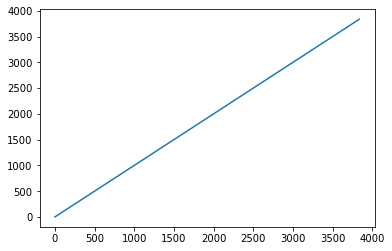

In [886]:
test['id'].plot();

In [887]:
train.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'body_type', 'body_type_add',
       'color_hex_add', 'condition', 'customs', 'description', 'drive',
       'engine_displacement', 'engine_power', 'fuel_type', 'loc_add',
       'location', 'mileage', 'model_date', 'model_date_add', 'name',
       'number_of_doors', 'owners', 'package', 'price', 'production_date',
       'pts', 'rating', 'steer', 'transmission', 'purchase_date', 'price_log',
       'model_age', 'mark_', 'drive_', 'engine_', 'wheels_', 'transmission_',
       'power_', 'count_', 'count_binned', 'age', 'age_binned',
       'age_reciprocal', 'vehicle_configuration', 'engine_vol', 'power_binned',
       'mileage_binned', 'mileage_peryear', 'months', 'months_isna'],
      dtype='object')

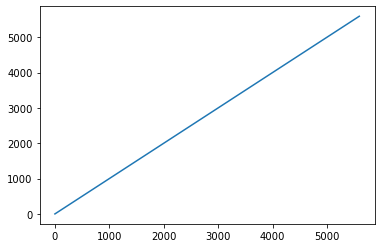

In [888]:
train['Unnamed: 0'].plot();

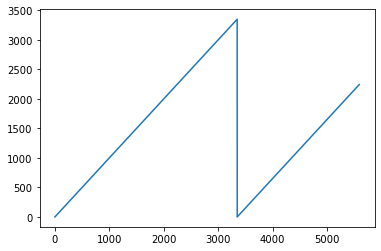

In [889]:
train['Unnamed: 0.1'].plot();

### Train - 'location' и 'loc_add'

Если мы будем использовать только автомобили, продающиеся в московском регионе, то эти признаки можно дропнуть, если нет, их значением можно поставить "Московский регион", а другим - в соответствии с тем, в каком регионе они продаются. В датафрейме test в этом случае можно предположить, что машины продаются в Москве и поставить "Московский регион".

In [890]:
train.location.value_counts(dropna=False).head(10)

Москва      4073
Тула          96
Химки         94
Тверь         71
Калуга        66
Владимир      53
Подольск      52
Рязань        49
Балашиха      47
Мытищи        43
Name: location, dtype: int64

In [891]:
train.loc_add.value_counts(dropna=False).head(10)

Москва      4073
Тула          96
Химки         94
Тверь         71
Калуга        66
Владимир      53
Подольск      52
Рязань        49
Балашиха      47
Мытищи        43
Name: loc_add, dtype: int64

In [892]:
# Видно, что значения этих признаков совпадают во всех записях датасета
train[train.location!=train.loc_add]

,Unnamed: 0,Unnamed: 0.1,body_type,body_type_add,color_hex_add,condition,customs,description,drive,engine_displacement,engine_power,fuel_type,loc_add,location,mileage,model_date,model_date_add,name,number_of_doors,owners,package,price,production_date,pts,rating,steer,transmission,purchase_date,price_log,model_age,mark_,drive_,engine_,wheels_,transmission_,power_,count_,count_binned,age,age_binned,age_reciprocal,vehicle_configuration,engine_vol,power_binned,mileage_binned,mileage_peryear,months,months_isna


### description


Попробуем выяснить, продается ли машина автосалоном ( обычно написано "автосалон" или его название, будем ловить словосочетания в кавычках, словосочетания капсом, а также будем выяснать, дает ли продавец гарантию ( так делают салоны ) и делает ли предпродажную подготовку ). Потом попробуем выделить в тексте ключевые слова, указывающие модели на положительные и отрицательные характеристики машины.

In [893]:
# Чтобы функции работали, заполним пропуски в train.description:
train.description.fillna(' ',inplace=True)

In [894]:
# Удаление \n - перевода строки
# test.description[1599]
line = re.sub(r'\n', '', test.description[1599])
# раскомментируй следующую строку и посмотри на это сочинение. Лев Толстой курит в сторонке.
# line

In [895]:
# Находим выражения в кавычках
def find_quotations(text):
    mtchs = re.findall(r'\"(.+?)\"',text)
    return ",".join(mtchs)

In [896]:
# находим выражения большими буквами на английском
def find_caps(text):
    mtchs = re.findall(r"([A-Z]+\s?[A-Z]+[^a-z0-9\W])",text)
    return ",".join(mtchs)


In [897]:
# находим выражения большими буквами на русском
def find_caps_rus(text):
    mtchs = re.findall(r"([А-Я]+\s?[А-Я]+[^а-я0-9\W])",text)
    return ",".join(mtchs)


In [898]:
# Хорошее описание с несколькими ключевыми словами: название салона, дилер, диагностика, кредит, автокредит, 
# Авторефинансирование, бонус
print(find_quotations(test.description[1597]))
print(find_caps(test.description[1597]))
print(find_caps_rus(test.description[1597]))
re.sub(r'\n', '', test.description[1597])

Авторефинансирование

РОЛЬФ,РОЛЬФ,РОЛЬФ,РОЛЬФ,РОЛЬФ


'РОЛЬФ Премиум – крупнейший официальный дилер Москвы\r\rВсе автомобили прошли:\r\r∙ Криминалистическую и юридическую проверку.\r∙ Комплексную диагностику, Вы получаете лист с официальным заключением о состоянии автомобиля.\r\rДополнительно РОЛЬФ подготовил для Вас 4 акции на данный автомобиль до конца месяца:\r\rАкция №1\r\rМаксимально выгодный кредит от 12,5%\r\rАкция №2\r\rТО в подарок при покупке в кредит автомобиля стоимостью до 2 000 000 руб.\r\rАкция №3\r\rИндивидуальное предложение от Руководителя направления при покупке в кредит автомобиля стоимостью свыше 2 000 000 руб.\r\rАкция №4\r\rУзнайте как вернуть переплату по кредиту.\r\rМы предлагаем:\r\r∙ Автокредит от 11,8% по двум документам одобрение за 1 час\r∙ Специальные условия при обмене на Ваш автомобиль\r∙ В наличии более 500 автомобилей с пробегом \r∙ Все автомобили прошли комплексную диагностику\r∙ Гарантия юридической чистоты\r∙ Более 150 комплектов колес и шин с пробегом по выгодной цене \r∙ Широкий ассортимент дополнит

In [899]:
s = test.description.apply(find_quotations)

In [900]:
# Кавычки. Названия салонов среди мусора, выбирать вручную - раскомментируйте!
# s.unique()

In [901]:
s_train = train.description.apply(find_quotations)

In [902]:
# s_train.unique()

In [903]:
#  Выбираем автосалоны ручками ('Trade' - так мы метим тех, кто себя не называет, ноо имеет Трейд-Ин):
resellers = ['Борис Хофф','Royal Motors Club','АВТО ПРЕСТИЖ','БалтАвтоТрейд',
            'Адванс авто','ABTODOM','Рольф','Авилон','Борисхоф','Авилон АГ',
            'Столичный Автодилер','Балтавтотрейд','Автодом','Автопорт','Ясенево',
            'Автотор','Независимость','Автомобильный Дом','AutoBye','АСЦ',
            'Балт-АвтоТрейд М','АВТОРУСЬ','Автоавангард','Inchcape Certified',
            'Inchcape','Trade','FAVORIT','РОЛЬФ','Royal Motors Club','ПАМАВТО-ТРЕЙД',
            'AVILON','Автолидер','АВТОМИР','Техинком','Азимут СП','MITINO-CARS','ОВОД'
            'АВТОКЛАСС']

In [904]:
s1 = test.description.apply(find_caps)

In [905]:
# Капс на английском. В основном мусор - раскомментируйте!
# s1.unique()

In [906]:
s2 = test.description.apply(find_caps_rus)

In [907]:
#Капс на русском. В основном мусор - надо раскомментировать след строки, чтобы посмотреть
#for string in s2.unique().tolist():
#    print(string)

Все(?!!! - это мое предположение) названия салонов так или иначе присутствуют в закавыченных словосочетаниях. Всего закавыченных сочетаний не так много. Поэтому можно рассортировать самые популярные слова в них в надежде выяснить список автосалонов. Чтобы это сделать ( разобрать на слова s.unique() и выяснить, какие из них употребляются чаще), надо освободиться от знаков препинания и служебных символов, строки разбить на слова и упорядочить эти слова по убыванию количества одинаковых в общей куче. Поехали.

In [908]:
# string.punctuation это полезная константа, содержащая все знаки препинания.
# Определяем функцию, переводящую каждую строку line  из нашего списка lst
# в нижний регистр, заменяющую пунктуацию, разделяющую строку на слова
# и удаляющую числа
def lst_to_words(lst):
    table = str.maketrans(dict.fromkeys('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', ' '))
    words = []
    for line in lst:
        words += line.lower().translate(table).split(' ')
    words = [w for w in words if (not w.isdigit() & (not w == ' '))]
    return words


In [909]:
words = lst_to_words(s.unique())

In [910]:
# Как выяснилось, названия салонов - не всегда самые популярные слова. Раскомментируйте, чтобы посмотреть!
from collections import Counter
most_common_words= [word for word, word_count in Counter(words).most_common()]
# most_common_words

In [911]:
# Итак, пытаемся пометить дилерские продажи на основе поля description, пользуясь списком дилеров resellers
def is_dealer(row):
    global resellers
    return any(dealer.lower() in row for dealer in resellers if not (('покупал' in row.lower()) or ('куплен' in row.lower())))

In [912]:
test['is_dealer'] = test.description.apply(is_dealer)

In [913]:
# Если наши предположения верны, 29% машин в тесте продаются дилерами
test.is_dealer.mean()

0.013291634089132134

__Проделаем аналогичную операцию с train.description__

In [914]:
train['is_dealer'] = train.description.apply(is_dealer)

In [915]:
# Если наши предположения верны, 16% машин в трейне продаются дилерами
train.is_dealer.mean()

0.01827956989247312

__По ходу дела я понял, что дилеры в базе очень сильно различаются__, например, одни из них находятся в Москве, другие в Минске, третьи в Калининграде, возможно, есть дилеры в Германии и Штатах. Соответственно. и уровень цен на схожие машины у них разный. Надо бы сделать колонку с указанием дилера. 

In [916]:
# Напишем для этого еще одну функцию:
def dealer_name(row):
    
    global resellers
    for dealer in resellers:
        if (dealer.lower() in row.lower()) and not (('покупал' in row.lower()) or ('куплен' in row.lower())):
            return dealer
    return 'no_dealer'
            
    

In [917]:
train['dealer_name'] = train.description.apply(dealer_name)

In [918]:
train.dealer_name.value_counts()

no_dealer             4697
Рольф                  294
Trade                  141
Автодом                110
ABTODOM                 97
Inchcape Certified      93
Борисхоф                33
Авилон                  23
Автопорт                22
АВТОМИР                 15
БалтАвтоТрейд           12
FAVORIT                  8
Royal Motors Club        8
АСЦ                      8
Inchcape                 4
AVILON                   4
АВТОРУСЬ                 3
Борис Хофф               3
Адванс авто              2
Автотор                  1
Независимость            1
Автоавангард             1
Name: dealer_name, dtype: int64

In [919]:
test['dealer_name'] = test.description.apply(dealer_name)

In [920]:
test.dealer_name.value_counts()

no_dealer              2819
Рольф                   200
ABTODOM                 158
Inchcape Certified      136
AVILON                  127
Trade                   127
АСЦ                      62
Автодом                  62
Авилон                   54
Борисхоф                 28
АВТОМИР                  16
AutoBye                   9
Royal Motors Club         8
АВТОРУСЬ                  8
БалтАвтоТрейд             6
Inchcape                  4
Азимут СП                 3
Борис Хофф                2
Автопорт                  2
АВТО ПРЕСТИЖ              1
Ясенево                   1
Столичный Автодилер       1
Балт-АвтоТрейд М          1
Автоавангард              1
Адванс авто               1
Name: dealer_name, dtype: int64

Некоторые частники пишут, что они когда-то покупали машину у дилера, и упоминают его название, совпадающее с элементом нашего списка resellers. Выясним, мноого ли таких частников мы по ошибке записали в дилеры?

In [921]:
# Много. Переписываем функцию!!!! Переделали. Теперь проверка прошла
mask = ((test.description.str.contains('покупал'))|(test.description.str.contains('куплен')))&\
        (test.dealer_name!='no_dealer')
len(test.loc[mask])

0

In [922]:
trn_dealer_lst = train.dealer_name.unique().tolist()
tst_dealer_lst = test.dealer_name.unique().tolist()
diff_dealer = [i for i in tst_dealer_lst if i not in trn_dealer_lst]

In [923]:
diff_dealer

['AutoBye',
 'Балт-АвтоТрейд М',
 'Азимут СП',
 'Ясенево',
 'Столичный Автодилер',
 'АВТО ПРЕСТИЖ']

In [924]:
cols_optional.append('dealer_name')

Похоже, у нас при попытке решить 1 проблему появилась другая - в тесте есть классы по признаку имени дилера, которые отсутствуют в трейне. Кроме того, классами охвачено только 16% машин, то есть задача почти не решена. Есть ли еще методы? __Да, есть!__ Вспоминаем, что вероятность выжить на титанике коррелировала с длиной фамилии пассажира. Итак, наши будущие новые признаки:

- количество букв ( включая пробелы и служебные ) в description
- количество цифр
- количество БОЛЬШИХ букв всего
- количество английских букв
- количество БОЛЬШИХ английских букв
- количество слов

Обычно длинные описания с обилием технических названий пишут желающие продать машину за максимальную цену или дилеры, дилеры также пишут много цифр - сколько вы сэкономите, если купите у них. Есть целый класс продавцов, который пишет description капсом, как это влияет на цену - не знаю.
Чтобы модель не потерялась в огромном количестве числовых, а не категориальных, значений, мы их сгруппируем, так же как значения пробега, с помощью функции binned(), задав геометрическую прогрессию границ ( смотритена длинные правые хвосты ниже ).

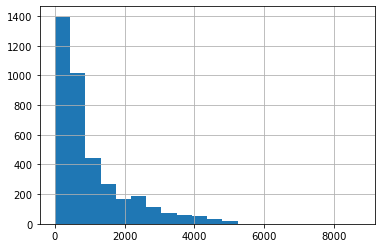

In [925]:
test[test.description.apply(len)<10000].description.apply(len).hist(bins=20);

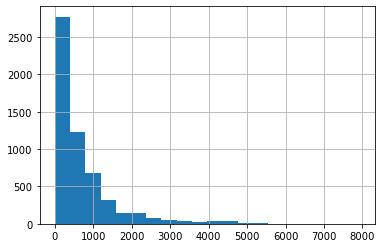

In [926]:
train[train.description.apply(len)<10000].description.apply(len).hist(bins=20);

In [927]:
lst = [2**i for i in range(14)]
lst

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

In [928]:
train['dsc_len_binned'] = train.description.apply(len).apply(binned).astype('int32')
test['dsc_len_binned'] = test.description.apply(len).apply(binned).astype('int32')

In [929]:
# Мы помним, что 226 записей train были без description
train.dsc_len_binned.value_counts().sort_index()

1        226
2          1
4          5
8         17
16        90
32       200
64       474
128      937
256     1313
512     1166
1024     727
2048     344
4096      79
8192       1
Name: dsc_len_binned, dtype: int64

In [930]:
test.dsc_len_binned.value_counts().sort_index()

4         1
8         4
16       23
32       66
64      194
128     424
256     881
512     973
1024    677
2048    503
4096     88
8192      3
Name: dsc_len_binned, dtype: int64

In [931]:
cols_for_model.append('dsc_len_binned')

In [932]:
# Ищем цифры
def nums(row):
    mtchs = re.findall(r'[0-9]+',row)
    return len(''.join(mtchs))
    


In [933]:
# Здесь нам хватит 9 групп
lst = [2**i for i in range(9)]
lst

[1, 2, 4, 8, 16, 32, 64, 128, 256]

In [934]:
train['dsc_nums_binned'] = train.description.apply(nums).apply(binned).astype('int32')
test['dsc_nums_binned'] = test.description.apply(nums).apply(binned).astype('int32')

In [935]:
train.dsc_nums_binned.value_counts().sort_index()

0      1543
1       237
2       465
4      1067
8      1052
16      694
32      244
64       64
128     211
256       3
Name: dsc_nums_binned, dtype: int64

In [936]:
test.dsc_nums_binned.value_counts().sort_index()

0      590
1      153
2      275
4      633
8      792
16     777
32     261
64     115
128    237
256      4
Name: dsc_nums_binned, dtype: int64

In [937]:
cols_for_model.append('dsc_nums_binned')

In [938]:
# Ищем заглавные буквы
def caps(row):
    mtchs = re.findall(r'[A-ZА-Я]+',row)
    return len(''.join(mtchs))

In [939]:
# Здесь нам хватит 11 групп
lst = [2**i for i in range(10)]
lst

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

In [940]:
train['dsc_caps_binned'] = train.description.apply(caps).apply(binned).astype('int32')
test['dsc_caps_binned'] = test.description.apply(caps).apply(binned).astype('int32')

In [941]:
train.dsc_caps_binned.value_counts().sort_index()

0       262
1       371
2       480
4       847
8      1141
16     1017
32      742
64      275
128     231
256     165
512      49
Name: dsc_caps_binned, dtype: int64

In [942]:
test.dsc_caps_binned.value_counts().sort_index()

0        9
1       88
2      187
4      400
8      778
16     751
32     512
64     482
128    259
256    252
512    119
Name: dsc_caps_binned, dtype: int64

In [943]:
cols_for_model.append('dsc_caps_binned')

In [944]:
# количество английских букв
def eng(row):
    mtchs = re.findall(r'[A-Za-z]+',row)
    return len(''.join(mtchs))

In [945]:
# Здесь нам хватит 12 групп
lst = [2**i for i in range(11)]
lst

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [946]:
train['dsc_eng_binned'] = train.description.apply(eng).apply(binned).astype('int32')
test['dsc_eng_binned'] = test.description.apply(eng).apply(binned).astype('int32')

In [947]:
# довольно многие не употребляют в описании английских букв
train.dsc_eng_binned.value_counts(dropna=False).sort_index()

0       2776
1        163
2        278
4        397
8        642
16       450
32       336
64       142
128      201
256      169
512       21
1024       5
Name: dsc_eng_binned, dtype: int64

In [948]:
test.dsc_eng_binned.value_counts(dropna=False).sort_index()

0       1410
1        107
2        164
4        336
8        385
16       473
32       354
64       202
128      164
256      204
512       29
1024       9
Name: dsc_eng_binned, dtype: int64

In [949]:
cols_for_model.append('dsc_eng_binned')

In [950]:
# количество БОЛЬШИХ английских букв
def engcaps(row):
    mtchs = re.findall(r'[A-Z]+',row)
    return len(''.join(mtchs))

In [951]:
# Здесь нам хватит 10 групп
lst = [2**i for i in range(9)]
lst

[1, 2, 4, 8, 16, 32, 64, 128, 256]

In [952]:
train['dsc_engcaps_binned'] =train.description.apply(engcaps).apply(binned).astype('int32')
test['dsc_engcaps_binned'] = test.description.apply(engcaps).apply(binned).astype('int32')

In [953]:
train.dsc_engcaps_binned.value_counts(dropna=False).sort_index()

0      3296
1       306
2       503
4       425
8       333
16      253
32      148
64      161
128     129
256      26
Name: dsc_engcaps_binned, dtype: int64

In [954]:
test.dsc_engcaps_binned.value_counts(dropna=False).sort_index()

0      1591
1       231
2       352
4       439
8       308
16      359
32      172
64      160
128     169
256      56
Name: dsc_engcaps_binned, dtype: int64

In [955]:
cols_for_model.append('dsc_engcaps_binned')

In [956]:
cols_for_model

['body_type',
 'color_hex_add',
 'fuel_type',
 'model_age',
 'transmission',
 'mark_',
 'engine_',
 'count_binned',
 'number_of_doors',
 'age',
 'age_reciprocal',
 'engine_vol',
 'engine_power',
 'mileage_binned',
 'mileage_peryear',
 'drive',
 'owners',
 'pts',
 'months_isna',
 'dsc_len_binned',
 'dsc_nums_binned',
 'dsc_caps_binned',
 'dsc_eng_binned',
 'dsc_engcaps_binned']

In [957]:
cols_optional

['drive_',
 'wheels_',
 'age_binned',
 'vehicle_configuration',
 'power_binned',
 'mileage',
 'dealer_name']

In [958]:
# Посчитаем количество слов в описании
def words(row):
    
    table = str.maketrans(dict.fromkeys('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', ' '))
    words = row.lower().translate(table).split(' ')
    words = [w for w in words if (not w.isdigit() & (not w == ' '))]
    return len(words)

In [959]:
train.description.apply(words).describe()

count    5580.000000
mean      111.081900
std       140.057515
min         1.000000
25%        32.000000
50%        70.000000
75%       146.000000
max      5481.000000
Name: description, dtype: float64

In [960]:
# Здесь нам хватит 12 групп
lst = [2**i for i in range(11)]
lst

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [961]:
train['words_binned'] = train.description.apply(words).apply(binned).astype('int32')
test['words_binned'] = test.description.apply(words).apply(binned).astype('int32')

In [962]:
train['words_binned'].value_counts(dropna=False).sort_index()

1          4
2        253
4        140
8        294
16       697
32      1197
64      1387
128     1053
256      452
512       99
1024       4
Name: words_binned, dtype: int64

In [963]:
test['words_binned'].value_counts(dropna=False).sort_index()

1          1
2          8
4         35
8         95
16       311
32       685
64      1071
128      910
256      523
512      193
1024       5
Name: words_binned, dtype: int64

In [964]:
cols_for_model.append('words_binned')

In [965]:
test[cols_for_model].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   body_type           3837 non-null   object
 1   color_hex_add       3837 non-null   object
 2   fuel_type           3837 non-null   object
 3   model_age           3837 non-null   int32 
 4   transmission        3837 non-null   object
 5   mark_               3837 non-null   object
 6   engine_             3837 non-null   object
 7   count_binned        3837 non-null   int32 
 8   number_of_doors     3837 non-null   object
 9   age                 3837 non-null   int32 
 10  age_reciprocal      3837 non-null   int32 
 11  engine_vol          3837 non-null   int32 
 12  engine_power        3837 non-null   int32 
 13  mileage_binned      3837 non-null   int32 
 14  mileage_peryear     3837 non-null   int32 
 15  drive               3837 non-null   object
 16  owners              3837

### Комплектация - package

In [966]:
import pprint
import json
pp = pprint.PrettyPrinter(indent=4)

In [967]:
# Функция, которая из каждой строки признаков теста делает словарь
def json_to_dict(row):
    
    # проверяем, не пусто ли там
    if len(row)<=4:
        return {}
    else:
        # если не пусто, делаем словарь
        loaded_row = json.loads(row[2:-2])
        row_dict = {}
        for x in loaded_row:
            row_dict[x['name']] = x['values']
        return row_dict


In [968]:
test['package_dict'] = test['Комплектация'].apply(json_to_dict)

In [969]:
lst_of_dicts_feats = test['package_dict'].tolist()

In [970]:
# Проверяем - получили очень длинный список словарей
# lst_of_dicts_feats

In [971]:
# Формируем словарь ( а вдруг понадобится ) всех списков фич, встречающихся в тесте, по группам - dict_of_test_feats

# Делаем список ключей объединенного словаря - страхуемся на случай того, что ключи 
# в разных записях могут различаться
keys_lst = []
for dct in lst_of_dicts_feats:
    keys_lst += dct.keys()
keys_lst = set(keys_lst)

# Общий словарь делаем сначала как словарь пустых списков по всем возможным ключам из теста
dict_of_test_feats = {elem:[] for elem in keys_lst}

# Наполняем списки
for dct in lst_of_dicts_feats:
    for key in dct.keys():
        dict_of_test_feats[key] += dct[key]

# Чистим списки от дубликатов фич
dict_of_test_feats = {key:list(set(val)) for key, val in dict_of_test_feats.items()}       
    

In [972]:
# dict_of_test_feats

In [973]:
# Функция, которая из строки фич трейна делает список фич
def json_to_list(row):
    
    # проверяем, не пусто ли там
    if len(row)<=2:
        return []
    else:
        # если не пусто, делаем список
        row = row.replace(': True','').replace('{','').replace('}','').replace("'",'')
        return row.split(', ')

In [974]:
# сделал колонку с простым списком всех фич данной машины
train['package_list'] = train.package.apply(json_to_list)

In [975]:
# Он очень длинный - это список всех таких списков
# train.package_list.tolist()   

In [976]:
# Собрал все фичи из колонки в одну кучу, так, чтобы не повторялось
features = list(set([feature for row in train.package_list.tolist() for feature in row]))

In [977]:
# Получил столько же фич, как Александр напарсил на Авто ру
len(features)

258

In [978]:
# Читаю список, который Александр напарсил
feats = pd.read_csv('c:/Users/User/Documents/GitHub/Wrecking-Crew-RDS-5/auto_feats.csv')

In [979]:
# Собрал в кучу все фичи из напарсенного списка
feats_lst = feats['0'].tolist()

In [980]:
# Интересуюсь разницей
diff_feats = [feature for feature in features if feature not in feats_lst]

In [981]:
# Вывод: в машинах нашего трейна есть ВСЕ фичи, что Александр напарсил, даже со странными названиями
diff_feats

[]

Но не все фичи одинаково полезны. Выберем те 20% из них, которые сильно коррелируют с ценами машин, присутствуют часто и есть в трейне и тесте (принцип Парето говорит нам, что 20% фич оказывают 80% влияния на цену). Начнем с трейна.


In [982]:
# для каждой фичи вычисляем импакт - среднюю абсолютную разницу цены машины с фичей и средней цены машины по датасету
impact = []
mean_price = train.price.mean()
for feature in features:
    mask = train.package_list.apply(lambda row: feature in row)
    impact.append(abs(train.loc[mask,'price'] - mean_price).mean())
feats_impact = pd.DataFrame({'feature' : features,
                                 'impact' : impact}, 
                                columns=['feature','impact'])

In [983]:
# выделяем 50 самых важных фич
feats_impact.sort_values(by='impact', axis=0, ascending=False,inplace=True)

In [984]:
# собираем их в список
important_feats = feats_impact.head(50).feature.tolist()

In [985]:
# Ручками находим перевод среди фич теста
important_feats_dict = {'22-inch-wheels':'Диски 22',
                         'laser-lights':'Лазерные фары',
                         'wireless-charger':'Беспроводная зарядка для смартфона',
                         'third-row-seats':'Третий ряд сидений',
                         'seats-6':'Количество мест: 6',
                         'body-kit':'Обвес кузова',
                         'alcantara':'Алькантара (Материал салона)',
                         'apple-carplay':'CarPlay',
                         'blind-spot':'Система контроля слепых зон',
                         'lane-keeping-assist':'Система контроля за полосой движения',
                         'traffic-sign-recognition':'Система распознавания дорожных знаков',
                         'auto-park':'Система автоматической парковки',
                         'collision-prevention-assist':'Система предотвращения столкновения',
                         '360-camera':'Камера 360°',
                         '21-inch-wheels':'Диски 21',
                         'remote-engine-start':'Дистанционный запуск двигателя',
                         'glonass':'ЭРА-ГЛОНАСС',
                         'air-suspension':'Пневмоподвеска',
                         'rear-seat-heat-vent':'Вентиляция задних сидений',
                         'projection-display':'Проекционный дисплей',
                         'night-vision':'Система ночного видения',
                         'front-seats-heat-vent':'Вентиляция передних сидений',
                         'activ-suspension':'Активная подвеска',
                         'armored':'Бронированный кузов',
                         'drowsy-driver-alert-system':'Датчик усталости водителя',
                         'laminated-safety-glass':'Ламинированные боковые стекла',
                         'power-latching-doors':'Доводчик дверей',
                         'android-auto':'Android Auto',
                         'electro-rear-seat':'Электрорегулировка задних сидений',
                         'easy-trunk-opening':'Открытие багажника без помощи рук',
                         'multizone-climate-control':'Климат-контроль многозонный',
                         'led-lights':'Светодиодные фары',
                         'keyless-entry':'Система доступа без ключа',
                         'high-beam-assist':'Система управления дальним светом',
                         'bas':'Система помощи при торможении (BAS, EBD)',
                         'electronic-gage-panel':'Электронная приборная панель',
                         'drive-mode-sys':'Система выбора режима движения',
                         'music-super':'Аудиосистема с TV',
                         'roller-blinds-for-rear-side-windows':'Солнцезащитные шторки в задних дверях',
                         'decorative-interior-lighting':'Декоративная подсветка салона',
                         'driver-seat-memory':'Память сиденья водителя',
                         'steering-wheel-gear-shift-paddles':'Подрулевые лепестки переключения передач',
                         'paint-metallic':'Металлик',
                         'panorama-roof':'Панорамная крыша / лобовое стекло',
                         'entertainment-system-for-rear-seat-passengers':'Мультимедиа система для задних пассажиров',
                         'sport-pedals':'Декоративные накладки на педали',
                         'seats-7':'Количество мест: 7',
                         'velvet-seats':'Велюр (Материал салона)',
                         'black-roof':'Отделка потолка чёрной тканью',
                         'rear-seats-heat':'Подогрев задних сидений'}

In [986]:
# Собираем словарь фич в датафрейм
important_feats_df = pd.DataFrame.from_dict(important_feats_dict,orient='index',columns=['russian']) 

In [987]:
# Приводим его в порядок
# important_feats_df.reset_index().rename(columns={'index':'english'})

In [988]:
# Записываем. чтобы не потерять!
important_feats_df.to_csv('c:/Users/user/Documents/GitHub/Wrecking-Crew-RDS-5/important_feats_df.csv')

In [989]:
# Для единообразия сделаем колонку комплектации в Тесте в виде списка фич
def dict_oflists_tolist(row):
    
    result = []
    for lst in row.values():
        result +=lst
    return result
        

In [990]:
test['package_list'] = test.package_dict.apply(dict_oflists_tolist)

In [991]:
test.package_list.head()

0    [Антипробуксовочная система (ASR), Система ста...
1    [Круиз-контроль, Мультифункциональное рулевое ...
2    [Круиз-контроль, Мультифункциональное рулевое ...
3    [Круиз-контроль, Система «старт-стоп», Электро...
4    [Круиз-контроль, Электрорегулировка руля, Муль...
Name: package_list, dtype: object

__На этапе обучения модели и прогноза мы разберем эти фичи в трейне и тесте на бинарные колонки__

### rating

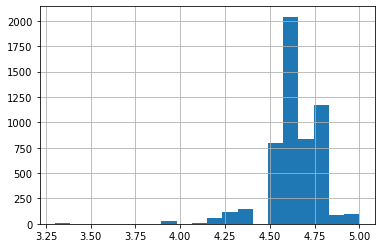

In [992]:
train.rating.hist(bins=20);

In [993]:
train.rating.value_counts(dropna=False).sort_index()

3.3       3
3.7       1
3.8       2
3.9      29
4.1       7
4.2      55
4.3     114
4.4     144
4.5     797
4.6    2041
4.7     838
4.8    1169
4.9      87
5.0      96
NaN     197
Name: rating, dtype: int64

In [994]:
# train.loc[train.rating.isna(),'name'].values

Часть рейтингов у нас отсутствует в трейне. Кроме того, они полностью отсутствуют в тесте. Мы сможем восстановить их, пользуясь имеющимися данными. Это будут наши метаданные, которые мы попытаемся использовать для улучшения прогноза цены.

In [995]:
# В этих наблюдениях нам надо восстановить признак rating
tst_idx = train[train.rating.isna()].index

In [996]:
# Эти наблюдения мы можем использовать для тренировки модели
trn_idx = train[~train.rating.isna()].index

In [343]:
# Вспоминаем
cols_for_model

['body_type',
 'color_hex_add',
 'fuel_type',
 'model_age',
 'transmission',
 'mark_',
 'engine_',
 'count_binned',
 'number_of_doors',
 'age',
 'age_reciprocal',
 'engine_vol',
 'engine_power',
 'mileage_binned',
 'mileage_peryear',
 'drive',
 'owners',
 'pts',
 'months_isna',
 'dsc_len_binned',
 'dsc_nums_binned',
 'dsc_caps_binned',
 'dsc_eng_binned',
 'dsc_engcaps_binned',
 'words_binned']

__При прогнозе рейтинга можно и нужно использовать данные о цене машины, у нас есть такие в трейне - пропущенные значения будем прогнозировать используя категориальный признак на основе логарифма цены машины ( мы помним, что логарифм распределен лучше, чем сама цена )__

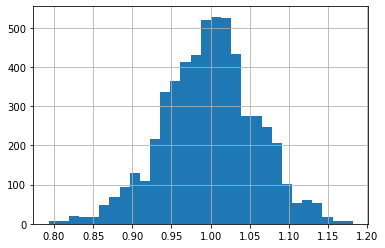

In [997]:
train.price_log.hist(bins=30)

In [999]:
lst = [round((0.8 + 0.02*i),ndigits=2) for i in range(20)]
lst

[0.8,
 0.82,
 0.84,
 0.86,
 0.88,
 0.9,
 0.92,
 0.94,
 0.96,
 0.98,
 1.0,
 1.02,
 1.04,
 1.06,
 1.08,
 1.1,
 1.12,
 1.14,
 1.16,
 1.18]

In [1022]:
train['price_log_binned'] = (train.price_log.apply(binned)*100).astype('int32')

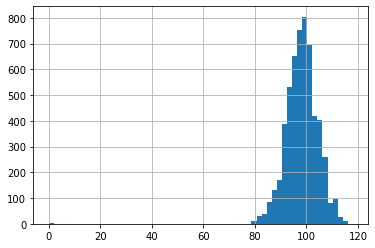

In [1023]:
train['price_log_binned'].hist(bins=60);

In [1024]:
# Делаем входные данные для модели
y = train.loc[trn_idx,'rating']

In [1025]:
X = train.loc[trn_idx,[*cols_for_model,'price_log_binned']]

In [1026]:
# Определим категориальные признаки
CAT_FEATURES_FOR_RATING = ['body_type',
                           'color_hex_add',
                           'fuel_type',
                           'transmission',
                           'mark_',
                           'engine_',
                           'number_of_doors',
                           'drive',
                           'owners',
                           'pts',
                           'months_isna'
                           ]

In [1027]:
# Для справки список всех признаков
[*cols_for_model,'price_log_binned']

['body_type',
 'color_hex_add',
 'fuel_type',
 'model_age',
 'transmission',
 'mark_',
 'engine_',
 'count_binned',
 'number_of_doors',
 'age',
 'age_reciprocal',
 'engine_vol',
 'engine_power',
 'mileage_binned',
 'mileage_peryear',
 'drive',
 'owners',
 'pts',
 'months_isna',
 'dsc_len_binned',
 'dsc_nums_binned',
 'dsc_caps_binned',
 'dsc_eng_binned',
 'dsc_engcaps_binned',
 'words_binned',
 'price_log_binned']

In [1028]:
# Сначало проверим качество модели
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

In [1029]:
model = CatBoostRegressor(iterations=5000,
                                  depth=4,
                                  l2_leaf_reg=2,
                                  learning_rate=0.1,
                                  random_seed=RANDOM_SEED,
                                  task_type='GPU',
                                  loss_function='MAPE'
                                  )


In [1030]:
model.fit(X_train, y_train,
         cat_features=CAT_FEATURES_FOR_RATING,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         plot=False
         )

0:	learn: 0.0230705	test: 0.0223599	best: 0.0223599 (0)	total: 42.2ms	remaining: 3m 31s
500:	learn: 0.0070651	test: 0.0080507	best: 0.0079960 (465)	total: 11.3s	remaining: 1m 41s
1000:	learn: 0.0064568	test: 0.0081204	best: 0.0079244 (715)	total: 22.3s	remaining: 1m 29s
1500:	learn: 0.0061352	test: 0.0080173	best: 0.0079244 (715)	total: 33.4s	remaining: 1m 17s
2000:	learn: 0.0057760	test: 0.0080199	best: 0.0079244 (715)	total: 44.9s	remaining: 1m 7s
2500:	learn: 0.0055612	test: 0.0081062	best: 0.0079244 (715)	total: 57.9s	remaining: 57.8s
3000:	learn: 0.0054092	test: 0.0082571	best: 0.0079244 (715)	total: 1m 10s	remaining: 47.2s
3500:	learn: 0.0052850	test: 0.0085147	best: 0.0079244 (715)	total: 1m 23s	remaining: 35.7s
4000:	learn: 0.0051510	test: 0.0087234	best: 0.0079244 (715)	total: 1m 35s	remaining: 23.8s
4500:	learn: 0.0050622	test: 0.0088788	best: 0.0079244 (715)	total: 1m 47s	remaining: 11.9s
4999:	learn: 0.0049425	test: 0.0091234	best: 0.0079244 (715)	total: 2m	remaining: 0us
b

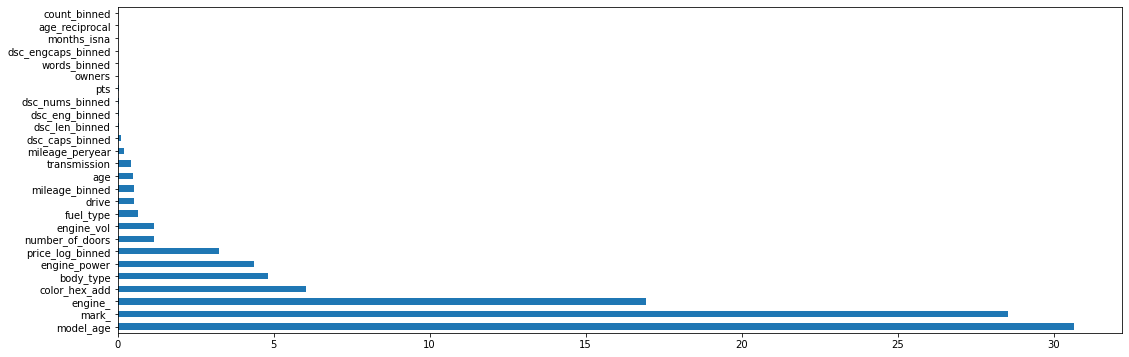

In [1031]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(18,6))
feat_importances.nlargest(30).plot(kind='barh');

In [1032]:
test_predict = model.predict(X_test)
test_score = mape(y_test, test_predict)

In [1033]:
test_score

0.007924354658143642

In [1034]:
metrics(y_test, test_predict)

RMSE = 0.08, MAE = 0.04, R-sq = 0.73, MAPE = 0.008 


__Мы получили хорошие метрики, теперь заполним пропуски в трейне__

In [1045]:
# Переопределяем датасеты:
X_train = train.loc[trn_idx,[*cols_for_model,'price_log_binned']]
y_train = train.loc[trn_idx,'rating']
X_test = train.loc[tst_idx,[*cols_for_model,'price_log_binned']]

In [1046]:
model = CatBoostRegressor(iterations=5000,
                                  depth=4,
                                  l2_leaf_reg=2,
                                  learning_rate=0.1,
                                  random_seed=RANDOM_SEED,
                                  task_type='GPU',
                                  loss_function='MAPE'
                                  )

model.fit(X_train, y_train,
         cat_features=CAT_FEATURES_FOR_RATING,
 #        eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=False,
         plot=False
         )

0:	learn: 0.0229330	total: 24.3ms	remaining: 2m 1s
500:	learn: 0.0075692	total: 11.1s	remaining: 1m 39s
1000:	learn: 0.0066883	total: 22.2s	remaining: 1m 28s
1500:	learn: 0.0061340	total: 33.3s	remaining: 1m 17s
2000:	learn: 0.0058268	total: 44.3s	remaining: 1m 6s
2500:	learn: 0.0055064	total: 55.3s	remaining: 55.3s
3000:	learn: 0.0053257	total: 1m 6s	remaining: 44.2s
3500:	learn: 0.0051631	total: 1m 17s	remaining: 33.2s
4000:	learn: 0.0050355	total: 1m 28s	remaining: 22.1s
4500:	learn: 0.0049441	total: 1m 39s	remaining: 11s
4999:	learn: 0.0048347	total: 1m 50s	remaining: 0us


In [1047]:
# Прогнозируем рейтинг там, где он пропущен
test_predict = model.predict(X_test)

In [1048]:
# Округляем, контролируем
np.round(test_predict,decimals=1)

array([4.7, 4.4, 4.7, 4.7, 4.8, 4.4, 4.6, 4.7, 4.9, 4.6, 4.4, 4.6, 4.4,
       4.6, 4.9, 4.6, 4.4, 4.6, 4.8, 4.5, 4.6, 4.8, 4.6, 4.9, 4.7, 4.7,
       4.4, 4.6, 4.8, 4.9, 4.7, 4.7, 4.6, 4.4, 4.4, 4.6, 4.9, 4.6, 4.7,
       4.6, 4.6, 4.6, 4.6, 4.9, 4.8, 4.6, 4.6, 4.6, 5. , 4.5, 4.9, 4.6,
       4.7, 4.4, 4.6, 4.8, 4.4, 4.4, 4.7, 4.5, 4.6, 4.8, 4.6, 4.8, 4.7,
       4.6, 4.8, 4.6, 4.6, 4.8, 4.9, 4.5, 4.4, 4.6, 4.6, 4.5, 4.9, 4.6,
       4.4, 4.7, 4.6, 4.7, 4.4, 4.7, 4.5, 4.9, 4.7, 4.7, 4.7, 4.6, 4.4,
       4.4, 4.6, 4.5, 4.6, 4.6, 5. , 4.2, 4.4, 4.5, 4.8, 4.6, 4.7, 4.7,
       4.4, 4.7, 4.4, 4.6, 4.6, 4.6, 4.6, 4.8, 5. , 4.7, 4.6, 4.7, 4.4,
       4.4, 5. , 4.6, 4.4, 4.7, 4.6, 4.5, 4.7, 4.6, 4.7, 4.6, 4.7, 4.6,
       4.6, 4.6, 4.4, 4.6, 4.6, 4.8, 4.4, 4.9, 4.4, 4.6, 4.6, 4.6, 4.4,
       4.4, 4.6, 4.6, 4.9, 4.4, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6,
       4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.7, 4.9, 4.6, 4.9, 4.7,
       4.4, 4.9, 4.6, 5. , 4.6, 4.6, 4.7, 4.4, 4.8, 4.4, 4.6, 4.

In [1049]:
# Присваиваем
train.loc[tst_idx,'rating'] = np.round(test_predict,decimals=1)

In [1050]:
# Проверяем - заполнили
train.rating.isna().sum()

0

__Заполним рейтинг в тесте (предположим, что он не изменился за 8 месяцев)__

In [1051]:
# У нас нет данных о ценах машин из теста, соответственно, в новой модели мы не используем информацию о цене машины
X_train = train[cols_for_model]
y_train = train['rating']
X_test = test[cols_for_model]

In [1052]:
# Узнаем качество модели путем кроссвалидации
N_FOLDS = 5
DEPTH = 4
L2_LEAF_REG = 2
LEARNING_RATE = 0.1

In [1056]:
# Импортируем модули
from catboost import Pool, cv

In [1058]:
cv_dataset = Pool( data=X_train,
                    label=y_train,
                    cat_features=CAT_FEATURES_FOR_RATING
                  )    
    
    # Фиксируем параметры
params = {'iterations':5000,
          'verbose_eval':500,
          'depth':DEPTH,
          'l2_leaf_reg':L2_LEAF_REG,
          'learning_rate':LEARNING_RATE,
          'random_seed':RANDOM_SEED,
          'task_type':'GPU',
          'loss_function':'MAPE'
         }
    
    # Запускаем
scores = cv(cv_dataset,
            params,
            early_stopping_rounds=500,
            fold_count=N_FOLDS, 
            plot=False
           )
    


0:	learn: 0.9953309	test: 0.9953334	best: 0.9953334 (0)
500:	learn: 0.0178682	test: 0.0201637	best: 0.0201637 (500)
1000:	learn: 0.0152022	test: 0.0181567	best: 0.0181556 (999)
1500:	learn: 0.0132456	test: 0.0165844	best: 0.0165844 (1500)
2000:	learn: 0.0119607	test: 0.0157360	best: 0.0157267 (1990)
2500:	learn: 0.0110462	test: 0.0150954	best: 0.0150954 (2500)
3000:	learn: 0.0103195	test: 0.0145688	best: 0.0145389 (2952)
3500:	learn: 0.0097052	test: 0.0140957	best: 0.0140926 (3490)
4000:	learn: 0.0091857	test: 0.0137845	best: 0.0137828 (3981)
4500:	learn: 0.0088024	test: 0.0134993	best: 0.0134800 (4469)
4999:	learn: 0.0084332	test: 0.0132703	best: 0.0132585 (4994)	total: 10m 4s	remaining: 0us


In [1059]:
# Результат неплохой, можно тренировать модель и заполнять пропуски рейтинга в тесте
scores.iloc[-1]

iterations         4999.000000
test-MAPE-mean        0.013270
test-MAPE-std         0.001650
train-MAPE-mean       0.008433
train-MAPE-std        0.000950
Name: 4999, dtype: float64

In [1060]:
model = CatBoostRegressor(iterations =5000,
                          depth=4,
                          l2_leaf_reg=2,
                          learning_rate=0.1,
                          random_seed = RANDOM_SEED,
                          task_type='GPU',
                          loss_function='MAPE'
                          )
model.fit(X_train, y_train,
         cat_features=cols_for_model,
 #        eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=False,
         plot=False
         )

0:	learn: 0.0229436	total: 27.7ms	remaining: 2m 18s
500:	learn: 0.0067450	total: 14.6s	remaining: 2m 10s
1000:	learn: 0.0056069	total: 27.5s	remaining: 1m 49s
1500:	learn: 0.0052487	total: 40.1s	remaining: 1m 33s
2000:	learn: 0.0049228	total: 53.5s	remaining: 1m 20s
2500:	learn: 0.0046637	total: 1m 8s	remaining: 1m 8s
3000:	learn: 0.0044745	total: 1m 23s	remaining: 55.4s
3500:	learn: 0.0043630	total: 1m 36s	remaining: 41.2s
4000:	learn: 0.0042463	total: 1m 51s	remaining: 27.9s
4500:	learn: 0.0041767	total: 2m 4s	remaining: 13.8s
4999:	learn: 0.0040767	total: 2m 17s	remaining: 0us


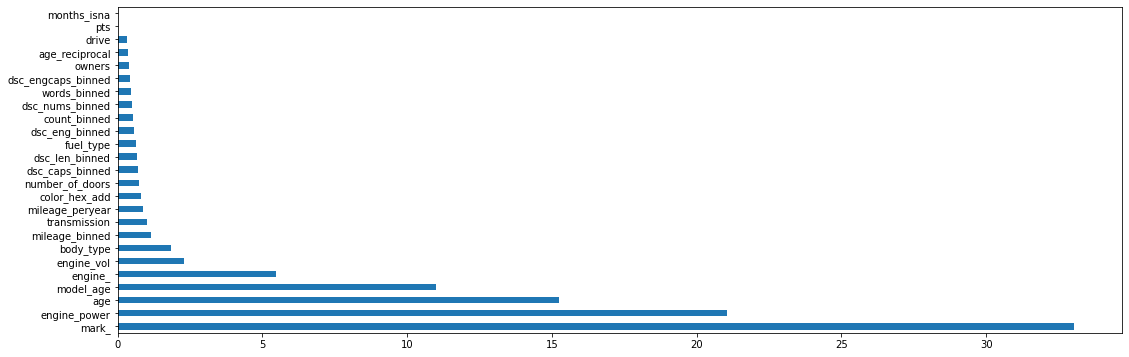

In [1062]:
# Удивительно, но картина отличается от предыдущей.
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
plt.figure(figsize=(18,6))
feat_importances.nlargest(30).plot(kind='barh');

In [1063]:
test_predict = model.predict(X_test)

In [1064]:
test['rating'] = np.round(test_predict,decimals=1)

In [1065]:
# Видим, что пропущенных значений не осталось
test.rating.value_counts(dropna=False).sort_index()

3.7       1
3.9       3
4.0       4
4.1       4
4.2      45
4.3      37
4.4     123
4.5     460
4.6    1193
4.7     829
4.8     916
4.9     166
5.0      53
5.1       3
Name: rating, dtype: int64

In [1066]:
train.rating = (train.rating*10).astype('int32')
test.rating = (test.rating*10).astype('int32')

In [1069]:
# Включим признак рейтинг в число признаков для модели, он будет числовым
cols_for_model.append('rating')

### Время владения - заполнение пропусков

In [1067]:
train[['months']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5580 entries, 0 to 5593
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   months  5580 non-null   int32
dtypes: int32(1)
memory usage: 225.4 KB


In [1068]:
train.months.value_counts().head()

9999    3429
17        45
27        42
24        41
13        39
Name: months, dtype: int64

In [1078]:
# Иначе модель принимает в расчет только этот признак - 'months_isna'
months_cols = [col for col in cols_for_model if col!='months_isna']

In [1081]:
# Пытаемся заполнить время владения в месяцах
df = train[[*cols_for_model,'months','price_log_binned']]

In [1082]:
trn_idx = df[~df.months_isna].index
tst_idx = df[df.months_isna].index

In [1083]:
X = df.loc[trn_idx,[*months_cols,'price_log_binned']]
y = df.loc[trn_idx,'months']

In [1084]:
CAT_FEATURES_FOR_MONTHS = [col for col in CAT_FEATURES_FOR_RATING if col!='months_isna']

In [1087]:
# Проведем кроссвалидацию на тех же параметрах, что и для рейтинга
cv_dataset = Pool( data=X,
                    label=y,
                    cat_features=CAT_FEATURES_FOR_MONTHS
                  )    
    
    # Фиксируем параметры
params = {'iterations':5000,
          'verbose_eval':500,
          'depth':DEPTH,
          'l2_leaf_reg':L2_LEAF_REG,
          'learning_rate':LEARNING_RATE,
          'random_seed':RANDOM_SEED,
          'task_type':'GPU',
          'loss_function':'MAPE'
         }
    
    # Запускаем
scores = cv(cv_dataset,
            params,
            early_stopping_rounds=500,
            fold_count=N_FOLDS, 
            plot=False
           )

0:	learn: 0.9951795	test: 0.9951855	best: 0.9951855 (0)
500:	learn: 0.9193919	test: 0.9227318	best: 0.9227318 (500)
1000:	learn: 0.8705113	test: 0.8776329	best: 0.8776329 (1000)
1500:	learn: 0.8320710	test: 0.8424372	best: 0.8424372 (1500)
2000:	learn: 0.8002263	test: 0.8139907	best: 0.8139907 (2000)
2500:	learn: 0.7754160	test: 0.7922028	best: 0.7922028 (2500)
3000:	learn: 0.7583343	test: 0.7774559	best: 0.7774559 (3000)
3500:	learn: 0.7469338	test: 0.7673226	best: 0.7673143 (3499)
4000:	learn: 0.7386248	test: 0.7595801	best: 0.7595801 (4000)
4500:	learn: 0.7312315	test: 0.7540297	best: 0.7540297 (4500)
4999:	learn: 0.7258689	test: 0.7498357	best: 0.7498285 (4997)	total: 9m 59s	remaining: 0us


In [1090]:
# Результат - отвратительный
scores.iloc[-1]

iterations         4999.000000
test-MAPE-mean        0.749836
test-MAPE-std         0.027388
train-MAPE-mean       0.725869
train-MAPE-std        0.012424
Name: 4999, dtype: float64

__Вывод: пропуски в колонке "months" заполнить не удалось, используем ее с пропусками, сохранив информацию о них__

In [1091]:
# Применим колонку months для модели
cols_for_model.append('months')

### Создание метапризнаков

Иногда бывает, что прямой прогноз целевой переменной не дает большой точности из-за особенностей зависимости ее от признаков или распределения ее значений на тренировочном датасете. Например, мы видели, что характер распределения логарифма цены гораздо ближе к нормальному, чем распределение самой цены. Это будет наш первый метапризнак.

In [1093]:
metafeats = ['price_log']

In [1094]:
train['price_sqrt'] = np.sqrt(train.price )

In [1095]:
PRICE_SQRT_MEDIAN = train.price_sqrt.median()
train['price_sqrt'] = train['price_sqrt']/PRICE_SQRT_MEDIAN

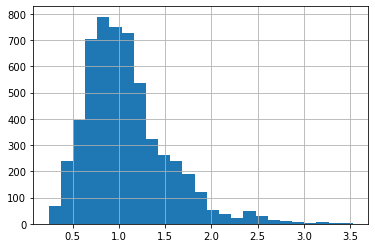

In [1100]:
# можно попробовать
train['price_sqrt'].hist(bins=25);

In [1096]:
# Обратная функция получается с незначительной погрешностью:
# t= (train['price_sqrt']*PRICE_SQRT_MEDIAN)**2

mape(train.price , (train['price_sqrt']*PRICE_SQRT_MEDIAN)**2)

6.776539641236074e-17

In [1097]:
metafeats.append('price_sqrt')

In [1098]:
train['price_mileage'] = (train.price_log)*(train.mileage + 10)

In [1099]:
PRICE_MILEAGE_MEDIAN = train.price_mileage.median()
train['price_mileage'] = train['price_mileage']/PRICE_MILEAGE_MEDIAN

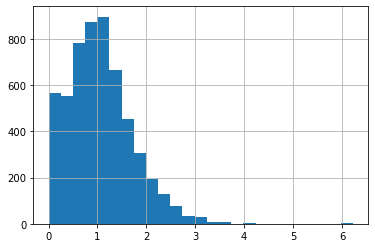

In [1101]:
train['price_mileage'].hist(bins=25);

In [1106]:
# Обратная функция получается с незначительной погрешностью:
t1 = (PRICE_MILEAGE_MEDIAN*train['price_mileage']/(train.mileage + 10)).apply(lambda row: (np.exp(row*PRICE_LOG_MEDIAN) - 1))
mape(train.price,t1)

9.459272477593862e-16

In [1107]:
metafeats.append('price_mileage')

In [1108]:
train['price_age'] = (train.price_log)*(train.age + 1)

In [1109]:
PRICE_AGE_MEDIAN = train.price_age.median()
train['price_age'] = train['price_age']/PRICE_AGE_MEDIAN

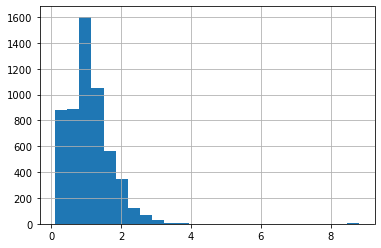

In [1110]:
train['price_age'].hist(bins=25);

In [1111]:
# Обратная функция получается с незначительной погрешностью:
t2 = (PRICE_AGE_MEDIAN*train['price_age']/(train.age + 1)).apply(lambda row: (np.exp(row*PRICE_LOG_MEDIAN) - 1))
mape(train.price,t2)

1.0257369488385596e-15

In [1112]:
metafeats.append('price_age')

In [1113]:
train['price_model_age'] = (train.price_log)*(train.model_age + 1)

In [1114]:
PRICE_MODEL_AGE_MEDIAN = train.price_model_age.median()
train['price_model_age'] = train['price_model_age']/PRICE_MODEL_AGE_MEDIAN

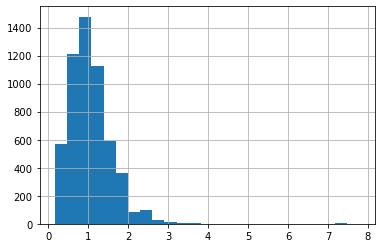

In [1115]:
train['price_model_age'].hist(bins=25);

In [1117]:
# Обратная функция получается с незначительной погрешностью:
t3 = (PRICE_MODEL_AGE_MEDIAN*train['price_model_age']/(train.model_age + 1)).\
      apply(lambda row: (np.exp(row*PRICE_LOG_MEDIAN) - 1))
mape(train.price,t3)

1.044207630172016e-15

In [1118]:
metafeats.append('price_model_age')

In [1119]:
train['price_power'] = (train.price_log)*(train.power_ + 10)

In [1120]:
PRICE_POWER_MEDIAN = train.price_power.median()
train['price_power'] = train['price_power']/PRICE_POWER_MEDIAN

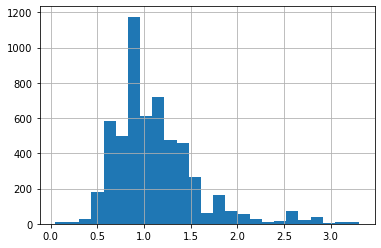

In [1121]:
train['price_power'].hist(bins=25);

In [1123]:
# Обратная функция получается с незначительной погрешностью:
t4 = (PRICE_POWER_MEDIAN*train['price_power']/(train.power_ + 10)).apply(lambda row: (np.exp(row*PRICE_LOG_MEDIAN) - 1))
mape(train.price,t4)

9.075000182938716e-16

In [1124]:
metafeats.append('price_power')

In [1125]:
train['price_vol'] = (train.price_log)*(train.engine_vol + 10)

In [1126]:
PRICE_VOL_MEDIAN = train.price_vol.median()
train['price_vol'] = train['price_vol']/PRICE_VOL_MEDIAN

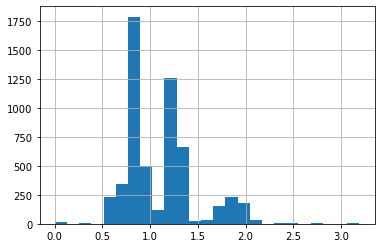

In [1127]:
train['price_vol'].hist(bins=25);

In [1128]:
# Обратная функция получается с незначительной погрешностью:
t5 = (PRICE_VOL_MEDIAN*train['price_vol']/(train.engine_vol + 10)).apply(lambda row: (np.exp(row*PRICE_LOG_MEDIAN) - 1))
mape(train.price,t5)

9.921829047906548e-16

In [1129]:
metafeats.append('price_vol')

In [1130]:
# train['price_agelog'] = (train.price_log)*(np.log(train.age + 1) + 1)

In [1131]:
# PRICE_AGELOG_MEDIAN = train.price_agelog.median()
# train['price_agelog'] = train['price_agelog']/PRICE_AGELOG_MEDIAN

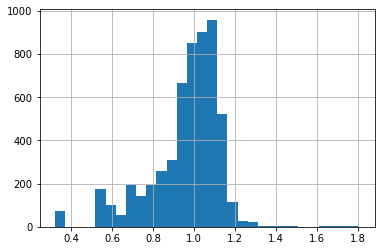

In [1132]:
# train['price_agelog'].hist(bins=30);

In [420]:
# metafeats.append('price_agelog')

In [421]:
# train['price_modelagelog'] = (train.price_log)*(np.log(train.model_age + 1) + 1)

In [422]:
PRICE_MODELAGELOG_MEDIAN = train.price_modelagelog.median()
train['price_modelagelog'] = train['price_modelagelog']/PRICE_MODELAGELOG_MEDIAN

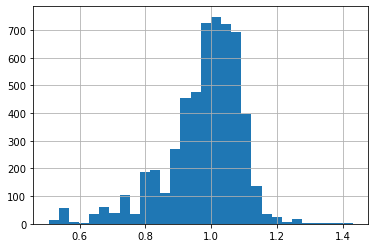

In [423]:
train['price_modelagelog'].hist(bins=30);

In [424]:
# metafeats.append('price_modelagelog')

In [425]:
# metafeats.append('price')

In [1133]:
# Наши метапризнаки
metafeats

['price_log',
 'price_sqrt',
 'price_mileage',
 'price_age',
 'price_model_age',
 'price_power',
 'price_vol']

In [428]:
# cols_for_model

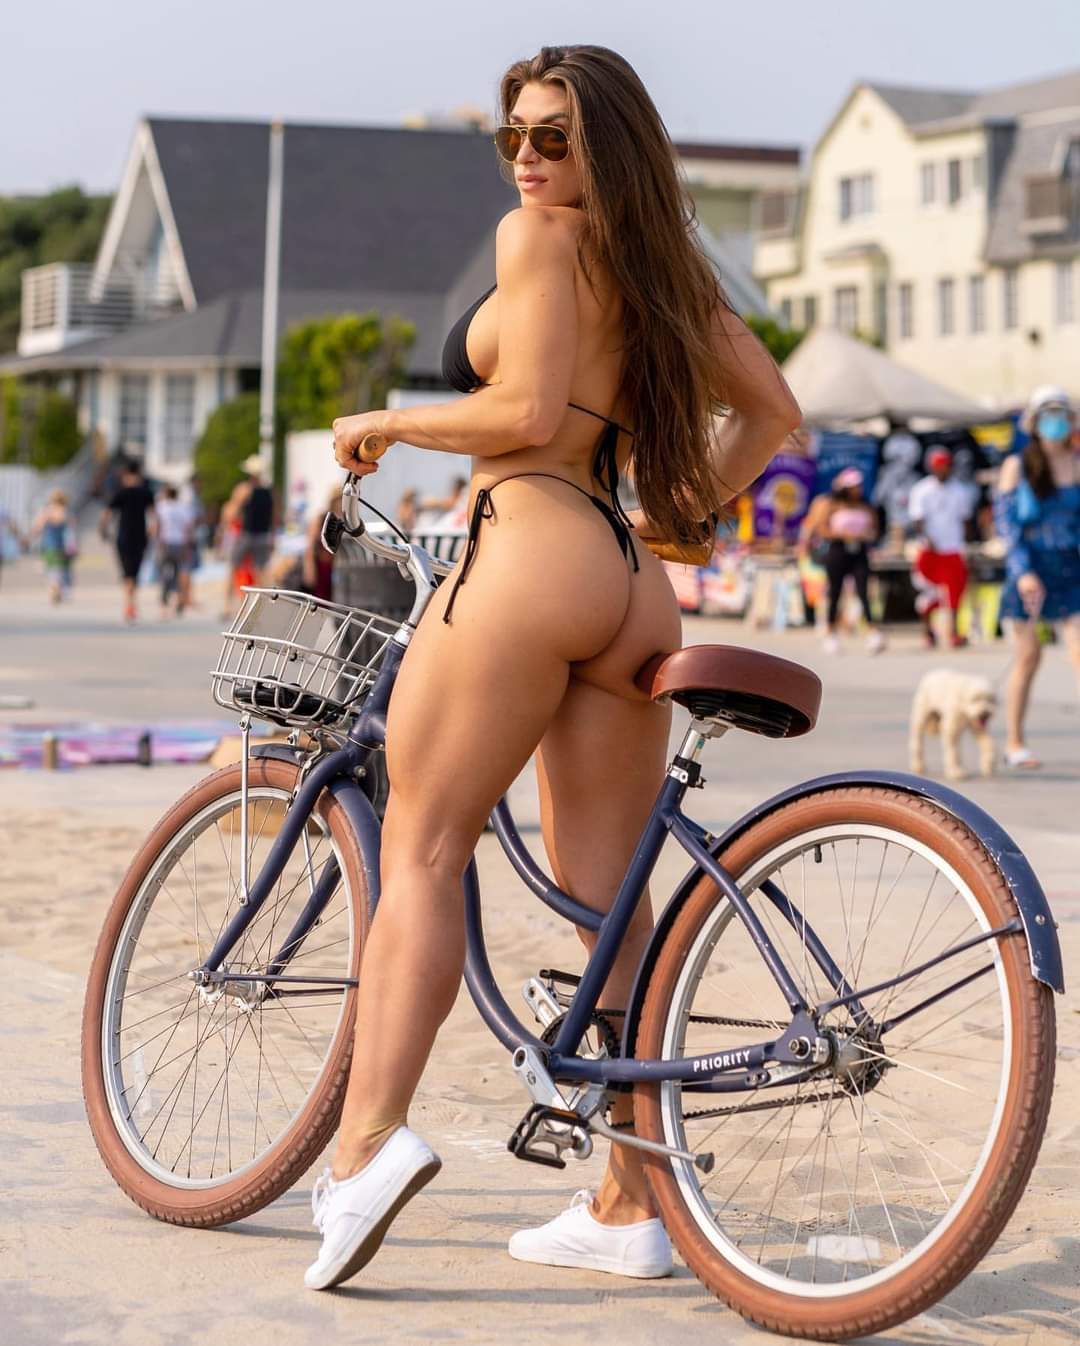

__Катя, подруга Маши, считает, что БМВ - это ведро с гайками. На пляж она ездит на велике, а в ночной клуб ее возят друзья. Она уже каталась на Майбахе, Мазератти, Бугатти и вертолете. Ну, а мы продолжаем.__

## CatBoost на трейне

Выясним, как пойдет прогноз наших метапризнаков и цены автомобиля, сначала на базовых параметрах CatBoost

In [429]:
# Целевую переменную мы будем выбирать в цикле, включающем цену и все метапризнаки, то есть колонку из Y
X = train[cols_for_model].copy()
Y = train[metafeats].copy()

In [430]:
# X.nunique()

In [431]:
# X.isna().sum()

In [432]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5567 entries, 0 to 5593
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price_log          5567 non-null   float64
 1   price_sqrt         5567 non-null   float64
 2   price_mileage      5567 non-null   float64
 3   price_age          5567 non-null   float64
 4   price_model_age    5567 non-null   float64
 5   price_power        5567 non-null   float64
 6   price_vol          5567 non-null   float64
 7   price_agelog       5567 non-null   float64
 8   price_modelagelog  5567 non-null   float64
 9   price              5567 non-null   float64
dtypes: float64(10)
memory usage: 478.4 KB


In [433]:
# Фиксируем размер проверочной выборки
VAL_SIZE = 0.25

In [434]:
# Фиксируем параметры модели
ITERATIONS = 2000
LR = 0.1

In [435]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5567 entries, 0 to 5593
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   body_type           5567 non-null   object
 1   color_hex_add       5567 non-null   object
 2   fuel_type           5567 non-null   object
 3   model_age           5567 non-null   int32 
 4   transmission        5567 non-null   object
 5   mark_               5567 non-null   object
 6   engine_             5567 non-null   object
 7   count_binned        5567 non-null   int32 
 8   number_of_doors     5567 non-null   object
 9   age                 5567 non-null   int32 
 10  age_reciprocal      5567 non-null   int32 
 11  engine_vol          5567 non-null   int32 
 12  engine_power        5567 non-null   int32 
 13  mileage_binned      5567 non-null   int32 
 14  mileage_peryear     5567 non-null   int32 
 15  drive               5567 non-null   object
 16  owners              5567

In [436]:
# Выделим категориальные колонки
CAT_FEATURES = ['body_type',
                 'color_hex_add',
                 'fuel_type',
                 'transmission',
                 'mark_',
                 'engine_',
                 'number_of_doors',
                 'drive',
                 'owners',
                 'pts',
                 'months_isna',
                 'rating']

In [437]:
# Определяем нашу функцию ошибок
# def mape_(y_true, y_pred):
#     return np.mean(np.abs((y_pred-y_true)/y_true))

In [438]:
# Определяем все параметры качества модели
# def metrics(y_true, y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
#     mape = mape_(y_true, y_pred)
#     return mse,rmse,r2,mae,mape

In [439]:
# Делаем пустой датасет для результатов
first_preds = pd.DataFrame(columns=['metafeature', 'feat_importances',
                                    'model', 'mape','ev_index', 'predicted'])

In [ ]:
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_pred-y_true)/y_true))

In [441]:
# Наполняем датасет first_preds
for i in range(len(metafeats)):
    
    print('Current feature is ',metafeats[i])
    
    # фиксируем текущую целевую переменную
    y = Y[metafeats[i]]
    
    # разбиваем
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
    model = CatBoostRegressor(iterations=5000,
                              depth=4,
                              l2_leaf_reg=2,
                              learning_rate=0.1,
                              random_seed = RANDOM_SEED,
                              task_type='GPU',
                              eval_metric='MAPE'
                              )
    
    # обучаем
    model.fit(X_train, y_train,
             cat_features=CAT_FEATURES,
             eval_set=(X_test, y_test),
             verbose_eval=500,
             use_best_model=True,
             early_stopping_rounds=500,
             plot=False
             )
    
    # выясняем важность признаков
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    
    # предсказываем
    predicted = model.predict(X_test)
    
    # считаем метрики
    mape_ = mape(y_test, predicted)
    
    # фиксируем индексы теста
    ev_index = X_test.index
    
    # добавляем в датасет
    first_preds.loc[i] = pd.Series({'metafeature':metafeats[i],
                                   'feat_importances':feat_importances,
                                   'model':model,
                                   'mape':mape_,
                                   'ev_index':ev_index,
                                   'true':y_test,
                                   'predicted':predicted
                                  })

Current feature is  price_log
0:	learn: 0.0422259	test: 0.0403012	best: 0.0403012 (0)	total: 26.7ms	remaining: 2m 13s
500:	learn: 0.0099238	test: 0.0098546	best: 0.0098546 (500)	total: 12.1s	remaining: 1m 48s
1000:	learn: 0.0093826	test: 0.0095539	best: 0.0095483 (997)	total: 24.3s	remaining: 1m 37s
1500:	learn: 0.0091575	test: 0.0094424	best: 0.0094422 (1499)	total: 36.4s	remaining: 1m 24s
2000:	learn: 0.0089436	test: 0.0094537	best: 0.0094140 (1781)	total: 48.5s	remaining: 1m 12s
bestTest = 0.009414004868
bestIteration = 1781
Shrink model to first 1782 iterations.
Current feature is  price_sqrt
0:	learn: 0.2534694	test: 0.2432692	best: 0.2432692 (0)	total: 25ms	remaining: 2m 4s
500:	learn: 0.0629308	test: 0.0611938	best: 0.0611703 (499)	total: 12.1s	remaining: 1m 48s
1000:	learn: 0.0611651	test: 0.0598051	best: 0.0597984 (766)	total: 24.4s	remaining: 1m 37s
1500:	learn: 0.0593355	test: 0.0583960	best: 0.0583878 (1430)	total: 36.5s	remaining: 1m 25s
2000:	learn: 0.0590684	test: 0.0586

In [442]:
#  Сохраняем на диске
first_preds.to_csv('c:/Users/user/Documents/GitHub/Wrecking-Crew-RDS-5/first_preds.csv')

In [457]:
first_preds = pd.read_csv('c:/Users/user/Documents/GitHub/Wrecking-Crew-RDS-5/first_preds.csv')

In [458]:
# Статистика на итерациях и конечный показатель mape говорят о том, что на большинстве метафич модель хорошо сходится 
# и вполне пригодна для прогноза. Особенно хороши первые 6 метафич. Заметим, что цена - нехорошая метафича!
first_preds.sort_values(by=['mape'])

,Unnamed: 0,metafeature,feat_importances,model,mape,mse,rmse,r2,mae,ev_index,predicted
0,0,price_log,body_type 0.979586\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.009773,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[1.04590193 1.13379065 1.02661216 ... 0.902832...
8,8,price_modelagelog,body_type 0.480068\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.011962,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.84196368 0.90129146 1.04159981 ... 1.097504...
7,7,price_agelog,body_type 0.065268\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.012601,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.66799315 0.81297993 1.0155422 ... 1.125308...
5,5,price_power,body_type 0.020986\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.023279,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.88965785 3.1832472 1.42520536 ... 0.711417...
4,4,price_model_age,body_type 0.035150\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.024690,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.5208149 0.50442333 1.08846178 ... 1.926438...
3,3,price_age,body_type 0.034186\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.033922,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.33638492 0.49122389 1.01685577 ... 1.994957...
1,1,price_sqrt,body_type 0.562313\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.071382,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[1.38362263 2.46833877 1.27691492 ... 0.516763...
6,6,price_vol,body_type 0.150990\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.083090,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.86751331 2.83789796 1.24946236 ... 0.922444...
9,9,price,body_type 0.196618\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.172053,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[1900950.53479367 5950983.22487303 1491366.318...
2,2,price_mileage,body_type 0.002008\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,2.236607,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.11916621 0.23151007 0.99277823 ... 1.685768...


In [459]:
first_preds = first_preds.sort_values(by=['mape'])[:6]

In [460]:
first_preds.reset_index(inplace=True)
first_preds.drop(columns=['index'],inplace=True)

In [481]:
first_preds

,Unnamed: 0,metafeature,feat_importances,model,mape,mse,rmse,r2,mae,ev_index,predicted
0,0,price_log,body_type 0.979586\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.009773,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[1.04590193 1.13379065 1.02661216 ... 0.902832...
1,8,price_modelagelog,body_type 0.480068\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.011962,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.84196368 0.90129146 1.04159981 ... 1.097504...
2,7,price_agelog,body_type 0.065268\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.012601,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.66799315 0.81297993 1.0155422 ... 1.125308...
3,5,price_power,body_type 0.020986\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.023279,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.88965785 3.1832472 1.42520536 ... 0.711417...
4,4,price_model_age,body_type 0.035150\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.024690,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.5208149 0.50442333 1.08846178 ... 1.926438...
5,3,price_age,body_type 0.034186\ncolor_hex_add...,<catboost.core.CatBoostRegressor object at 0x0...,0.033922,NaN,NaN,NaN,NaN,"Int64Index([1178, 775, 475, 1127, 4955, 1443...",[0.33638492 0.49122389 1.01685577 ... 1.994957...


__Вывод: по крайней мере 6 из предложенных нами метафич пригодны для блендинга и стакинга__

## Подбор параметров CatBoost

In [482]:
# X = df.loc[df.test==0,[*cols_for_model,*important_feats]]
X = train[cols_for_model]

In [483]:
# Тюним параметры на целевой функции - логарифме цены, 
# так как эта метафича показала наименьшую ошибку на предварительном прогоне
y = train['price_log']

In [484]:
# В таком варианте задание выполняется дольше, но результат лучше
CAT_FEATURES = ['body_type',
                 'color_hex_add',
                 'fuel_type',
                 'transmission',
                 'mark_',
                 'engine_',
                 'number_of_doors',
                 'drive',
                 'owners',
                 'pts',
                 'months_isna',
                 'rating']

# ,*important_feats]

In [485]:
ITERATIONS

2000

In [486]:
model = CatBoostRegressor(iterations = ITERATIONS,
                          cat_features=CAT_FEATURES,
                          random_seed = RANDOM_SEED,
                          task_type='GPU',
                          eval_metric='MAPE')

grid = {'learning_rate': [0.03, 0.1, 0.3],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 2, 3]}

grid_search_result = model.grid_search(grid, 
                                       X=X, 
                                       y=y,
                                       cv=3,
                                       partition_random_seed=0,
                                       calc_cv_statistics=True,
                                       search_by_train_test_split=True,
                                       refit=True,
                                       shuffle=True,
                                       stratified=None,
#                                        train_size=0.8,
                                       verbose=True,
                                       plot=False)

bestTest = 0.02044226066
bestIteration = 1989
0:	loss: 0.0204423	best: 0.0204423 (0)	total: 48.9s	remaining: 28m 32s
bestTest = 0.01655134307
bestIteration = 1977
1:	loss: 0.0165513	best: 0.0165513 (1)	total: 1m 38s	remaining: 27m 45s
bestTest = 0.01935486134
bestIteration = 1997
2:	loss: 0.0193549	best: 0.0165513 (1)	total: 2m 27s	remaining: 26m 57s
bestTest = 0.02005154697
bestIteration = 1992
3:	loss: 0.0200515	best: 0.0165513 (1)	total: 3m 17s	remaining: 26m 18s
bestTest = 0.01861595209
bestIteration = 1999
4:	loss: 0.0186160	best: 0.0165513 (1)	total: 4m 5s	remaining: 25m 24s
bestTest = 0.01891929585
bestIteration = 1935
5:	loss: 0.0189193	best: 0.0165513 (1)	total: 4m 54s	remaining: 24m 33s
bestTest = 0.01983224126
bestIteration = 1999
6:	loss: 0.0198322	best: 0.0165513 (1)	total: 5m 43s	remaining: 23m 42s
bestTest = 0.01719160611
bestIteration = 1981
7:	loss: 0.0171916	best: 0.0165513 (1)	total: 6m 32s	remaining: 22m 52s
bestTest = 0.01945282612
bestIteration = 1962
8:	loss: 0.0

In [487]:
# Разбираем результат
grid_search_result.keys()

dict_keys(['params', 'cv_results'])

In [488]:
# Наилучшие параметры (в поиске с 50 фичами было DEPTH = 4)
grid_search_result['params']

{'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [489]:
# Запишем их в константы
DEPTH = 4
L2_LEAF_REG = 2
LEARNING_RATE = 0.1

In [490]:
grid_search_result['cv_results'].keys()

dict_keys(['iterations', 'test-MAPE-mean', 'test-MAPE-std', 'train-MAPE-mean', 'train-MAPE-std', 'test-RMSE-mean', 'test-RMSE-std', 'train-RMSE-mean', 'train-RMSE-std'])

In [491]:
# Число итераций - 2000 - совпало
grid_search_result['cv_results']['iterations'][-1]

1999

In [492]:
# Лучшее среднее значение абсолютной ошибки  - около 1 %,
grid_search_result['cv_results']['test-MAPE-mean'][-1],grid_search_result['cv_results']['train-MAPE-mean'][-1],

(0.010789053892968891, 0.009508110980653439)

In [493]:
# Лучшее значение стандартного отклонения - 0.02% на тесте и 0.03% на трейне
grid_search_result['cv_results']['test-MAPE-std'][-1],grid_search_result['cv_results']['train-MAPE-std'][-1],

(0.00027322560834595417, 0.0003460342906674292)

## Кроссвалидация

In [494]:
# X = df.loc[df.test==False,[*cols_for_model,*important_feats]].copy()
X = train[cols_for_model].copy()
Y = train[metafeats].copy()

In [495]:
# Импортируем модули
from catboost import Pool, cv

In [496]:
# Число фолдлов
N_FOLDS = 5

In [497]:
# Делаем пустой датасет для результатов
cv_results= pd.DataFrame(columns=['metafeature', 'iterations',
                                    'test-MAPE-mean', 'test-MAPE-std', 'train-MAPE-mean', 'train-MAPE-std'])

In [498]:
for i in range(len(metafeats)):
    # фиксируем текущую метафичу
    print('Current feature is ',metafeats[i])
    
    # Надо привыкать
    cv_dataset = Pool(data=X,
                      label=Y[metafeats[i]],
                      cat_features=CAT_FEATURES)
    
    
    # Фиксируем параметры
    params = {'iterations':5000,
              'verbose_eval':500,
              'depth':DEPTH,
              'l2_leaf_reg':L2_LEAF_REG,
              'learning_rate':LEARNING_RATE,
              'random_seed':RANDOM_SEED,
              'task_type':'GPU',
              'loss_function':'MAPE'}
    # Запускаем
    scores = cv(cv_dataset,
                params,
                early_stopping_rounds=500,
                fold_count=N_FOLDS, 
                plot=False)
    
    # Записываем результат
    cv_results.loc[i,['iterations','test-MAPE-mean', 'test-MAPE-std', 'train-MAPE-mean', 'train-MAPE-std']] = scores.iloc[-1]
    cv_results.loc[i,['metafeature']] = metafeats[i]
    
    

Current feature is  price_log
0:	learn: 0.8804238	test: 0.8807251	best: 0.8807251 (0)
500:	learn: 0.0361893	test: 0.0448370	best: 0.0361283 (108)
Stopped by overfitting detector  (500 iterations wait)
Current feature is  price_sqrt
0:	learn: 0.7942700	test: 0.7945477	best: 0.7945477 (0)
500:	learn: 0.0941760	test: 0.0992482	best: 0.0991888 (498)
1000:	learn: 0.0737480	test: 0.0856471	best: 0.0855095 (989)
1500:	learn: 0.0629877	test: 0.0798804	best: 0.0798804 (1500)
2000:	learn: 0.0574677	test: 0.0780793	best: 0.0779252 (1990)
2500:	learn: 0.0538314	test: 0.0779737	best: 0.0778003 (2395)
Stopped by overfitting detector  (500 iterations wait)
Current feature is  price_mileage
0:	learn: 0.7087927	test: 0.7087923	best: 0.7087923 (0)
500:	learn: 0.1643777	test: 0.1701580	best: 0.1701580 (500)
1000:	learn: 0.1141773	test: 0.1297301	best: 0.1296252 (990)
1500:	learn: 0.0863201	test: 0.1066017	best: 0.1066017 (1500)
2000:	learn: 0.0742604	test: 0.0993751	best: 0.0992592 (1983)
2500:	learn: 0.

In [499]:
# Сохранили результат
cv_results

,metafeature,iterations,test-MAPE-mean,test-MAPE-std,train-MAPE-mean,train-MAPE-std
0,price_log,608,0.0480857,0.00208893,0.0366482,0.000283191
1,price_sqrt,2895,0.0792778,0.00672039,0.0518657,0.00816775
2,price_mileage,4986,0.0812436,0.005316,0.0419832,0.00675865
3,price_age,3577,0.0635106,0.00485213,0.038952,0.0067275
4,price_model_age,2686,0.0591556,0.00653601,0.0402142,0.00649431
5,price_power,1933,0.0506509,0.00533726,0.0378906,0.00648882
6,price_vol,1656,0.0454422,0.000915585,0.0348241,0.00251453
7,price_agelog,1070,0.0489346,0.00257312,0.0372237,0.00140902
8,price_modelagelog,781,0.0487224,0.00284196,0.0371476,0.000247591
9,price,500,1,0,1,0


In [500]:
# Перед подсчетом средних метрик удалим из таблицы price, как явно бесперспективную
cv_results.drop(labels=[9],axis=0,inplace=True)

In [501]:
# Создадим строку, куда занесем усредненные метрики
cv_results.loc["Mean"] = cv_results.mean()

In [502]:
cv_results

,metafeature,iterations,test-MAPE-mean,test-MAPE-std,train-MAPE-mean,train-MAPE-std
0,price_log,608,0.0480857,0.00208893,0.0366482,0.000283191
1,price_sqrt,2895,0.0792778,0.00672039,0.0518657,0.00816775
2,price_mileage,4986,0.0812436,0.005316,0.0419832,0.00675865
3,price_age,3577,0.0635106,0.00485213,0.038952,0.0067275
4,price_model_age,2686,0.0591556,0.00653601,0.0402142,0.00649431
5,price_power,1933,0.0506509,0.00533726,0.0378906,0.00648882
6,price_vol,1656,0.0454422,0.000915585,0.0348241,0.00251453
7,price_agelog,1070,0.0489346,0.00257312,0.0372237,0.00140902
8,price_modelagelog,781,0.0487224,0.00284196,0.0371476,0.000247591
Mean,NaN,2243.56,0.0583359,0.00413126,0.0396388,0.00434348


__Вывод: для прогнозирования с помощью CatBoost подходят все метапризнаки, кроме самой цены ( я делал еще достаточно много попыток сравнительного прогнозирования на различных параметрах, везде цена прогнозируется хуже всего, но мы можем спрогнозировать метапризнаки, а цену потом вычислить на основе каждого из них ). Число итераций я бы увеличил до 3000.__


In [503]:
metafeats.remove('price')

In [1134]:
# Итак, по итогам кроссвалидации
metafeats

['price_log',
 'price_sqrt',
 'price_mileage',
 'price_age',
 'price_model_age',
 'price_power',
 'price_vol']

## Fit, Predict, блендинг.

В случае регрессии, когда целевая переменная численная, блендинг - это усреднение значений спрогнозированной переменной для каждого наблюдения по некоторому ансамблю прогнозов. При этом о величине будущей функции ошибок можно будет судить по функции ошибок на трейне и результатам кроссвалидации (

In [1135]:
#Добавляем колонки, соответствующие фичам машины. Вспоминаем, что important_feats - опции пакета комплектации машины
for feature in important_feats:
    train[feature] = train.package_list.apply(lambda row: feature in row)
    test[feature] = test.package_list.apply(lambda row: important_feats_dict[feature] in row)

In [1147]:
CAT_FEATURES = ['body_type',
                 'color_hex_add',
                 'fuel_type',
                 'transmission',
                 'mark_',
                 'engine_',
                 'number_of_doors',
                 'drive',
                 'owners',
                 'pts',
                 'months_isna',
                 *important_feats]


In [1137]:
# Целевую переменную мы будем выбирать в цикле, включающем цену и все метапризнаки, то есть колонку из Y
X = train[[*cols_for_model,*important_feats]].copy()
Y = train[metafeats].copy()
X_test = test[[*cols_for_model,*important_feats]].copy()

In [1150]:
# Делаем пустой датасет для результатов
preds = pd.DataFrame(columns=['metafeature', 'feat_importances',
                              'model','mape','train_actual', 'train_predicted', 'test_predicted'])

In [1151]:
for i in range(len(metafeats)):                     # len(metafeats)
    # фиксируем текущую метафичу
    print('Current feature is ',metafeats[i])
    
    # Видно, что в различных запусках модель использует разные признаки.Здесь мы попытаемся усредниться
    
    train_predicted_ = []
    test_predicted_ = []
    models = []    
    mape_lst = []
    feat_importances_ = []
    
    # чтобы усреднить случайности ( беггинг - 1 ступень), пробежимся по списку разных random_seed
    for j in range(10):
   
        # определяем модель
        model = CatBoostRegressor(iterations=5000,
                                  depth=4,
                                  l2_leaf_reg=2,
                                  learning_rate=0.1,
                                  random_seed=(RANDOM_SEED+j*37),
                                  task_type='GPU',
                                  loss_function='MAPE'
                                  )

        # Запускаем
        # обучаем
        model.fit(X,
                  Y[metafeats[i]],
                  cat_features=CAT_FEATURES,
                  sample_weight=None,
                  baseline=None,
                  use_best_model=True,
                  eval_set=(X, Y[metafeats[i]]),
                  verbose=True,
                  plot=False,
                  column_description=None,
                  metric_period=500,
                  silent=None,
                  early_stopping_rounds=500,
                  save_snapshot=None,
                  snapshot_file=None,
                  snapshot_interval=None,
                  init_model=None
                  )

        # выясняем важность признаков
        feat_importances_.append(pd.Series(model.feature_importances_, index=X.columns))

        # предсказываем и пополняем список
        train_predicted = model.predict(X)
        test_predicted = model.predict(X_test)

        # считаем метрики и пополняем списки
        mape_ = mape(Y[metafeats[i]].values, train_predicted)
        
        # добавляем в датасет
        preds.loc[i*10 + j] = pd.Series({
                                'metafeature':metafeats[i],
                                'feat_importances':pd.Series(model.feature_importances_, index=X.columns),
                                'model':model,
                                'mape':mape_,                            
                                'train_actual':Y[metafeats[i]].values,
                                'train_predicted':train_predicted,
                                'test_predicted':test_predicted
                                })
   

Current feature is  price_log
0:	learn: 0.0442643	test: 0.0423038	best: 0.0423038 (0)	total: 25.9ms	remaining: 2m 9s
500:	learn: 0.0359129	test: 0.0432553	best: 0.0338720 (15)	total: 11.5s	remaining: 1m 43s
bestTest = 0.0338720014
bestIteration = 15
Shrink model to first 16 iterations.
0:	learn: 0.0438564	test: 0.0420680	best: 0.0420680 (0)	total: 24.1ms	remaining: 2m
500:	learn: 0.0364720	test: 0.0437465	best: 0.0343667 (18)	total: 12.4s	remaining: 1m 51s
bestTest = 0.0343666733
bestIteration = 18
Shrink model to first 19 iterations.
0:	learn: 0.0437623	test: 0.0425901	best: 0.0425901 (0)	total: 28.1ms	remaining: 2m 20s
500:	learn: 0.0359055	test: 0.0404042	best: 0.0334412 (20)	total: 12.2s	remaining: 1m 49s
bestTest = 0.0334412086
bestIteration = 20
Shrink model to first 21 iterations.
0:	learn: 0.0430402	test: 0.0409833	best: 0.0409833 (0)	total: 23.8ms	remaining: 1m 59s
500:	learn: 0.0358613	test: 0.0438913	best: 0.0336795 (21)	total: 11.6s	remaining: 1m 43s
bestTest = 0.0336794836

500:	learn: 0.0397426	test: 0.0467536	best: 0.0456078 (387)	total: 12.1s	remaining: 1m 48s
bestTest = 0.04560777671
bestIteration = 387
Shrink model to first 388 iterations.
0:	learn: 0.3079997	test: 0.3083954	best: 0.3083954 (0)	total: 25.9ms	remaining: 2m 9s
500:	learn: 0.0401363	test: 0.0484482	best: 0.0479891 (431)	total: 11.7s	remaining: 1m 45s
1000:	learn: 0.0377621	test: 0.0502960	best: 0.0477661 (591)	total: 23.2s	remaining: 1m 32s
bestTest = 0.04776608047
bestIteration = 591
Shrink model to first 592 iterations.
0:	learn: 0.3080180	test: 0.3078431	best: 0.3078431 (0)	total: 24.3ms	remaining: 2m 1s
500:	learn: 0.0410827	test: 0.0489938	best: 0.0480832 (422)	total: 11.7s	remaining: 1m 44s
bestTest = 0.04808318436
bestIteration = 422
Shrink model to first 423 iterations.
0:	learn: 0.3080294	test: 0.3083620	best: 0.3083620 (0)	total: 25.5ms	remaining: 2m 7s
500:	learn: 0.0404049	test: 0.0471461	best: 0.0468798 (493)	total: 11.5s	remaining: 1m 43s
1000:	learn: 0.0380114	test: 0.050

500:	learn: 0.0348429	test: 0.0372812	best: 0.0372812 (500)	total: 11.4s	remaining: 1m 42s
1000:	learn: 0.0331803	test: 0.0383481	best: 0.0361296 (681)	total: 22.7s	remaining: 1m 30s
bestTest = 0.03612963495
bestIteration = 681
Shrink model to first 682 iterations.
0:	learn: 0.1880412	test: 0.1862196	best: 0.1862196 (0)	total: 23.7ms	remaining: 1m 58s
500:	learn: 0.0363144	test: 0.0383926	best: 0.0378144 (472)	total: 11.6s	remaining: 1m 43s
bestTest = 0.0378143584
bestIteration = 472
Shrink model to first 473 iterations.
0:	learn: 0.1881141	test: 0.1854273	best: 0.1854273 (0)	total: 24.1ms	remaining: 2m
500:	learn: 0.0338652	test: 0.0366846	best: 0.0320843 (332)	total: 9.03s	remaining: 1m 21s
bestTest = 0.03208433308
bestIteration = 332
Shrink model to first 333 iterations.
0:	learn: 0.1881970	test: 0.1858493	best: 0.1858493 (0)	total: 28.6ms	remaining: 2m 23s
500:	learn: 0.0363454	test: 0.0403249	best: 0.0386788 (321)	total: 11.8s	remaining: 1m 46s
bestTest = 0.038678777
bestIteration

In [1196]:
preds.head()

,metafeature,feat_importances,model,mape,train_actual,train_predicted,test_predicted
0,price_log,body_type 0.449831 color_hex_add ...,<catboost.core.CatBoostRegressor object at 0x0...,0.034787,"[1.011883891407235, 1.0840078075203807, 1.0144...","[1.0082012066850439, 1.0434693887655158, 1.028...","[1.0790499098075088, 1.1049192091741133, 0.990..."
1,price_log,body_type 1.588594 color_hex_add ...,<catboost.core.CatBoostRegressor object at 0x0...,0.035575,"[1.011883891407235, 1.0840078075203807, 1.0144...","[1.0259038793158197, 1.0145052936277352, 0.928...","[1.0577061951044016, 0.9915487642865628, 1.017..."
2,price_log,body_type 0.893580 color_hex_add ...,<catboost.core.CatBoostRegressor object at 0x0...,0.034382,"[1.011883891407235, 1.0840078075203807, 1.0144...","[1.0079586193605792, 1.0673997119010892, 1.012...","[1.0651003208186012, 1.072567108203657, 0.9781..."
3,price_log,body_type 1.022356 color_hex_add ...,<catboost.core.CatBoostRegressor object at 0x0...,0.034756,"[1.011883891407235, 1.0840078075203807, 1.0144...","[1.022706292453222, 1.091228583798511, 1.04601...","[1.0499530005035922, 1.0305375857860781, 1.017..."
4,price_log,body_type 1.621035 color_hex_add ...,<catboost.core.CatBoostRegressor object at 0x0...,0.033482,"[1.011883891407235, 1.0840078075203807, 1.0144...","[1.0433699790155515, 1.1072785650612786, 0.960...","[1.0408612486207858, 1.0110364147694781, 0.975..."


__Наша таблица preds - база для блендинга и частично стакинга__

In [1153]:
# Сохраним ее!
preds.to_csv('c:/Users/user/Documents/GitHub/Wrecking-Crew-RDS-5/preds_for_blending.csv')

In [1162]:
# Попробуем вычислить предсказания цен машин трейна и усреднить их
prices = (preds[preds.metafeature=='price_log'].train_predicted).apply(lambda row: (np.exp(row*PRICE_LOG_MEDIAN) - 1))

In [1164]:
prices_blended = np.mean(np.array(prices.values.tolist()),axis=0)

In [1179]:
# Похоже, наша модель неплохо предсказала сама себя
mape(train.price.values,prices_blended)

0.28709538897185677

In [1180]:
# Попробуем вычислить предсказания цен машин трейна и усреднить их
test_prices = (preds[preds.metafeature=='price_log'].test_predicted).apply(lambda row: (np.exp(row*PRICE_LOG_MEDIAN) - 1))

In [1181]:
test_prices_blended = np.mean(np.array(test_prices.values.tolist()),axis=0)

In [1192]:
# Вспоминаем про валютные курсы, которые с января месяца сильно поменялись. 
# Сабмиты с ноутбука команды показали, что 0.915 - хороший поправочный коэффицент на курс. Применим его.
test_prices_blended = test_prices_blended*0.915

In [1185]:
sample = pd.read_csv('c:/Users/user/Documents/GitHub/Wrecking-Crew-RDS-5/sample_submission.csv')

In [1188]:
sample.head()

,id,price
0,0,5299000.0
1,1,1580000.0
2,2,2000000.0
3,3,2199000.0
4,4,935000.0


In [1193]:
sample = sample.assign(price=test_prices_blended)

In [1194]:
sample.head()

,id,price
0,0,2.123904e+06
1,1,2.284109e+06
2,2,1.026440e+06
3,3,2.468390e+06
4,4,4.173605e+06


In [1195]:
sample.to_csv('c:/Users/user/Documents/GitHub/Wrecking-Crew-RDS-5/submission1.csv',index=False)

In [ ]:
К сожалению, получил скор 30.11710.

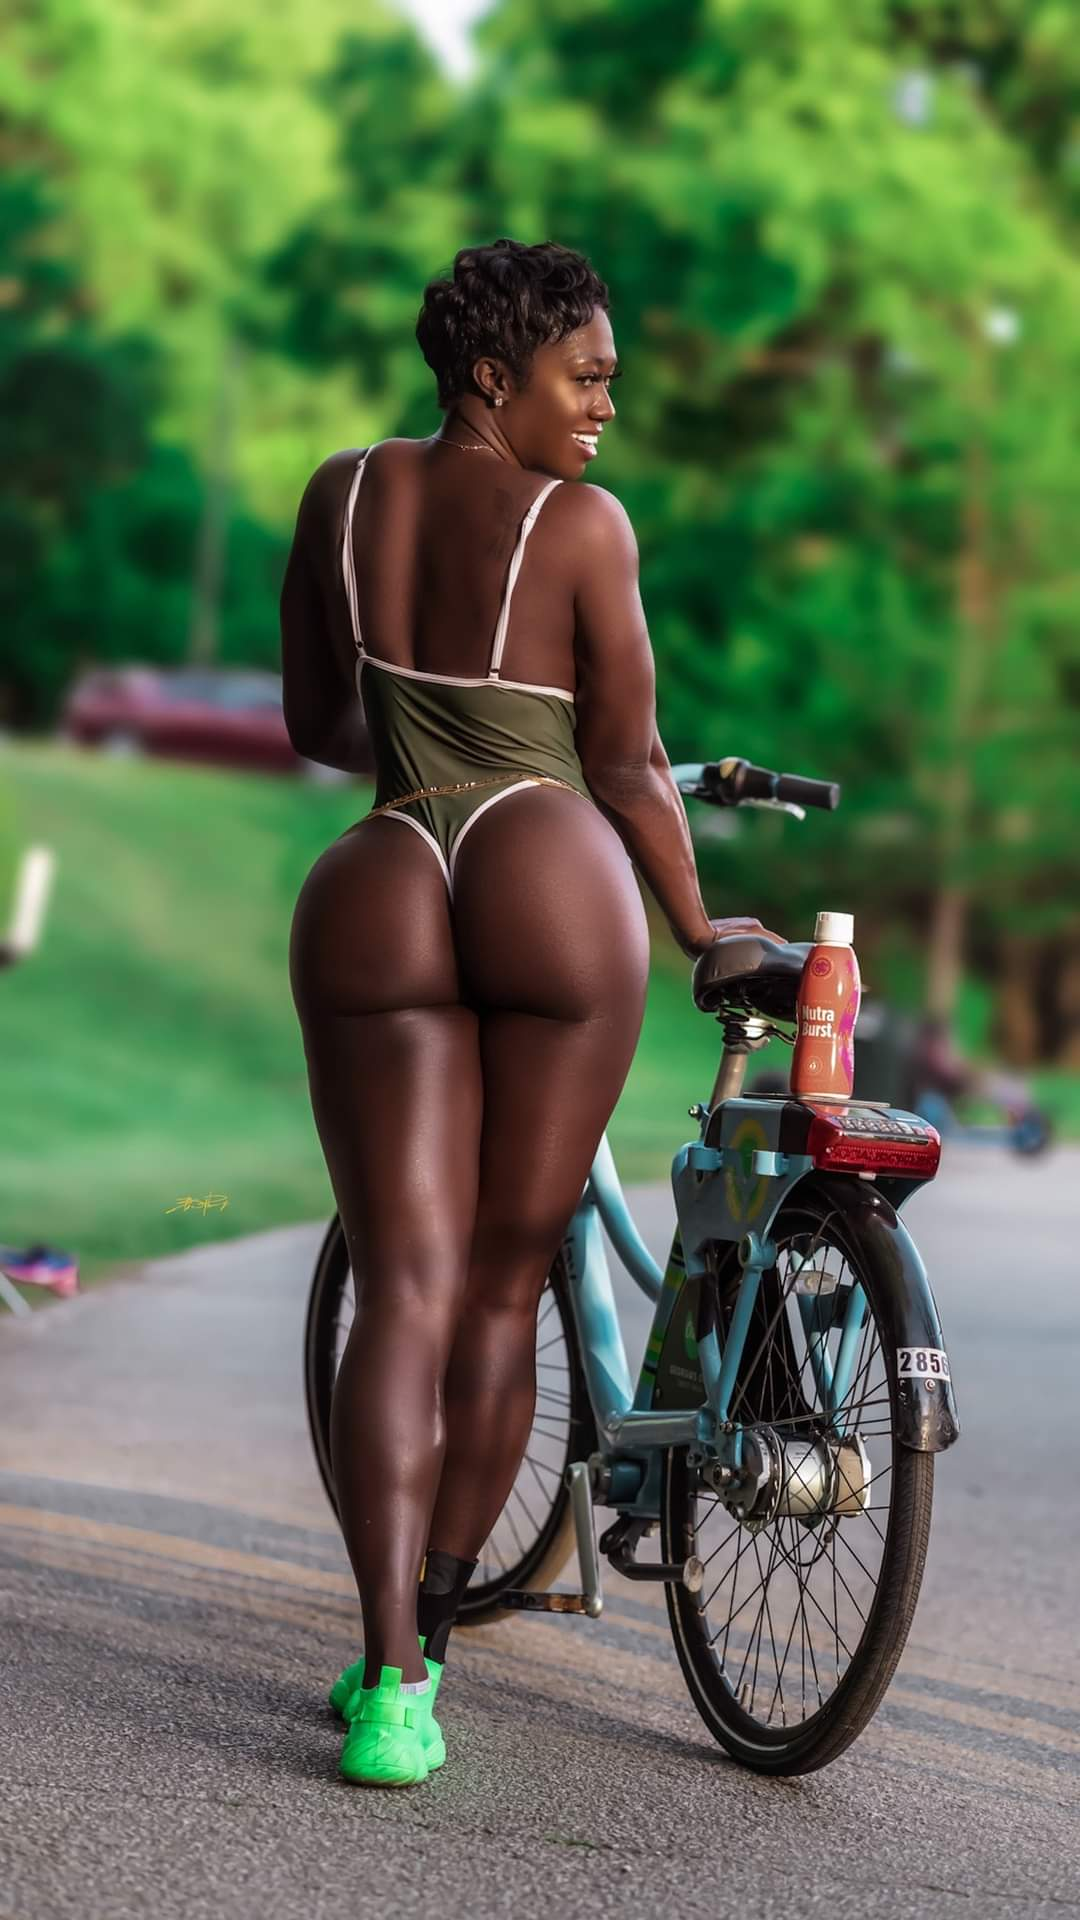

__А Надя, другая подруга, говорит, что, покупая БМВ, ты раскармливаешь мировой олигархоз и вредишь природе. К тому же на БМВ ты никогда так красиво не загоришь, как на велике.__